# Superstore Data Analysis

This project is a comprehensive analysis of the [Superstore orders dataset](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final/data).

The project contains the following four main sections:

1. Data Preprocessing
2. Exploratory Data Analysis
3. Customer RFM Segmentation
4. Future Sales Forecast

In [1]:
# imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import math

In [2]:
### helper plotting functions

def set_titles(title, x_label=None, y_label=None):
    plt.title(title)
    
    if x_label is not None:
        plt.xlabel(x_label)
        
    if y_label is not None:
        plt.ylabel(y_label)


def plot_piechart(values, labels, title, colors=None):
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors)
    set_titles(title)
    
    plt.show()
    

def plot_vertical_barchart(categories, values, title, x_label, y_label, colors=None):
    plt.bar(categories, values, color=colors)
    set_titles(title, x_label, y_label)
    
    plt.show()
    
    
def plot_horizontal_barchart(categories, values, title, x_label, y_label, vline=None, vline_label=None, figsize=None, colors=None):
    
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    plt.barh(categories, values, color=colors)
    
    if vline is not None:
        plt.axvline(vline, color="red", linestyle="--", label=vline_label)
        plt.legend()
        
    set_titles(title, x_label, y_label)
    
    plt.show()
    
    
def plot_lineplot(x, y, title, x_label, y_label, hline=None, hline_label=None,
                  figsize=None, x_ticks=None):
    
    if figsize is not None:
        plt.figure(figsize=figsize)
        
    plt.plot(x, y)
    
    if hline is not None:
        plt.axhline(y=hline, linestyle="--", color="r", label=hline_label)
        plt.legend()
    
    set_titles(title, x_label, y_label)
    
    if x_ticks is not None:
        plt.xticks(ticks=x_ticks)
        
    plt.show()
    
    
def plot_scatterplot(x, y, title, x_label, y_label, hline=None, figsize=None, x_ticks=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
        
    plt.scatter(x, y)
    set_titles(title, x_label, y_label)
    
    if hline is not None:
        plt.axhline(hline, color="r", linestyle="--")
        
    if x_ticks is not None:
        plt.xticks(ticks=x_ticks)
    
    plt.show()

## Data Preprocessing

### Import the Data

Let us import and display the data:

In [3]:
data = pd.read_csv("superstore.csv", encoding='ISO-8859-1')
data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,03/03/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,03/03/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,03/03/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


As we can see, the data contains the following attributes:

- Row ID - Unique ID for each row.
- Order ID - Unique Order ID for each Customer.
- Order Date - Order Date of the product.
- Ship Date - Shipping Date of the Product.
- Ship Mode - Shipping Mode specified by the Customer.
- Customer ID - Unique ID to identify each Customer.
- Customer Name - Name of the Customer.
- Segment - The segment where the Customer belongs.
- Country - Country of residence of the Customer.
- City - City of residence of of the Customer.
- State - State of residence of the Customer.
- Postal Code - Postal Code of every Customer.
- Region - Region where the Customer belong.
- Product ID - Unique ID of the Product.
- Category - Category of the product ordered.
- Sub-Category - Sub-Category of the product ordered.
- Product Name - Name of the Product
- Sales - Sales of the Product.
- Quantity - Quantity of the Product.
- Discount - Discount provided.
- Profit - Profit/Loss incurred.

Note that our dataframe already contains a default index, thus we can remove the 'Row ID' column.


### Basic Characteristics

Let us explore the basic characteristics of the data:

**Data dtypes:**

In [4]:
data.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

As we can see, the 'Order Date' and 'Ship Date' columns are of string dtype. However, they represent
dates. Thus, for easier analysis, we will convert them to datetime dtype.

For the rest of the columns, it appears each has the appropriate dtype.



**Missing values:**

In [5]:
data.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

As we can see, our data does not contain any missing values.

Hence, we do not need to impute or remove any records.

### Preprocessing

Let us perform the actions discussed in the previous sections.

In addition, in order to reduce the cognitive load in our future visualizations, we will convert the states' names into their codes (e.g. Florida -> FL)

Moreover, we will add the following columns:

- Order Month - the year and month of the order date
- Discount Amount - the total amount of the given discount from the sale.
- Net Sales - the net sales amount (sales amount - discount amount).

In [6]:
us_states_codes = {
    "Kentucky": "KY",
    "California": "CA",
    "Florida": "FL",
    "North Carolina": "NC",
    "Washington": "WA",
    "Texas": "TX",
    "Wisconsin": "WI",
    "Utah": "UT",
    "Nebraska": "NE",
    "Pennsylvania": "PA",
    "Illinois": "IL",
    "Minnesota": "MN",
    "Michigan": "MI",
    "Delaware": "DE",
    "Indiana": "IN",
    "New York": "NY",
    "Arizona": "AZ",
    "Virginia": "VA",
    "Tennessee": "TN",
    "Alabama": "AL",
    "South Carolina": "SC",
    "Oregon": "OR",
    "Colorado": "CO",
    "Iowa": "IA",
    "Ohio": "OH",
    "Missouri": "MO",
    "Oklahoma": "OK",
    "New Mexico": "NM",
    "Louisiana": "LA",
    "Connecticut": "CT",
    "New Jersey": "NJ",
    "Massachusetts": "MA",
    "Georgia": "GA",
    "Nevada": "NV",
    "Rhode Island": "RI",
    "Mississippi": "MS",
    "Arkansas": "AR",
    "Montana": "MT",
    "New Hampshire": "NH",
    "Maryland": "MD",
    "District of Columbia": "DC",
    "Kansas": "KS",
    "Vermont": "VT",
    "Maine": "ME",
    "South Dakota": "SD",
    "Idaho": "ID",
    "North Dakota": "ND",
    "Wyoming": "WY",
    "West Virginia": "WV"
}

In [7]:
# drop the 'Row ID' column
data.drop("Row ID", axis=1, inplace=True)

# cast the 'Order Date' column to datetime dtype
data["Order Date"] = pd.to_datetime(data["Order Date"])

# cast the 'Ship Date' column to datetime dtype
data["Ship Date"] = pd.to_datetime(data["Ship Date"])

# convert each state name into its code
data["State"] = data["State"].apply(lambda x: us_states_codes[x])

# create the 'Order Month' column
data["Order Month"] = data["Order Date"].dt.to_period('M')

# create the 'Discount Amount' column
data["Discount Amount"] = data["Sales"] * data["Discount"]

# create the 'Net Sales' column
data["Net Sales"] = data["Sales"] - data["Discount Amount"]

# display the transformed data
data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Order Month,Discount Amount,Net Sales
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,KY,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016-11,0.000000,261.960000
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,KY,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016-11,0.000000,731.940000
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,CA,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016-06,0.000000,14.620000
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,FL,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015-10,430.909875,526.667625
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,FL,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015-10,4.473600,17.894400


## Exploratory Data Analysis

In this section, we will perform exploratory data analysis (EDA) in order to uncover key insights and support data-driven decisions.

### General Metrics

In this section we will explore various general metrics.

**Overall Metrics:**

In [8]:
total_months = math.ceil((data["Order Date"].max() - data["Order Date"].min()).days / 30)
total_orders = data["Order ID"].nunique()
total_customers = data["Customer ID"].nunique()
total_sales = data["Sales"].sum()
total_net_sales = data["Net Sales"].sum()
total_profit = data["Profit"].sum()
total_items = data["Quantity"].sum()
unique_items_num = data["Product ID"].nunique()

print(f"Sales time period: {total_months} months")
print(f"Total sales: {total_sales:.0f}")
print(f"Total net sales: {total_net_sales:.0f}")
print(f"Total profit: {total_profit:.0f}")
print(f"Total number of orders: {total_orders}")
print(f"Total number of customers: {total_customers}")
print(f"Total number of products sold: {total_items}")
print(f"Total number of unique products: {unique_items_num}")

Sales time period: 49 months
Total sales: 2297201
Total net sales: 1974619
Total profit: 286397
Total number of orders: 5009
Total number of customers: 793
Total number of products sold: 37873
Total number of unique products: 1862


From the above results we can conclude:

- The given time period is 49 months (~4 years).
- The total sales amount is ~2.3 million.
- The total profit is ~290K.
- The overall profit amount is ~12% of the entire sales.
- The overall discount amount is ~15% of the entire sales.
- The total number of orders is ~5k.
- The total number of unique customers is ~800.
- The total number of products sold is ~40k.
- The store sells ~1.85k unique products.

**Mean Metrics:**

In [9]:
avg_month_sales = total_sales / total_months
avg_month_profit = total_profit / total_months
avg_customer_sale = total_sales / total_customers
avg_customer_profit = total_profit / total_customers
avg_order_sale = total_sales / total_orders
avg_order_profit = total_profit / total_orders
avg_customer_order = total_orders / total_customers
avg_order_item = total_items / total_orders

print(f"Average sales per month: {avg_month_sales:.2f}")
print(f"Average profit per month: {avg_month_profit:.2f}")
print(f"Average sales per customer: {avg_customer_sale:.2f}")
print(f"Average profit per customer: {avg_customer_profit:.2f}")
print(f"Average sales per order: {avg_order_sale:.2f}")
print(f"Average profit per order: {avg_order_profit:.2f}")
print(f"Average orders per customer: {avg_customer_order:.2f}")
print(f"Average items per order: {avg_order_item:.2f}")

Average sales per month: 46881.65
Average profit per month: 5844.84
Average sales per customer: 2896.85
Average profit per customer: 361.16
Average sales per order: 458.61
Average profit per order: 57.18
Average orders per customer: 6.32
Average items per order: 7.56


From the above results we can conclude:

- The average sales amount per month is ~47K.
- The average profit amount per month is ~6k.
- The average sales amount per customer is ~2.9k.
- The average profit amount per customer ~360.
- The average sales amount per order is ~460.
- The average profit amount per order is ~57.
- Each customer makes ~6 orders by average.
- Each order contains ~8 items be average.

### Products

In this section, we will analyze the store's products by various aspects.

#### Product Categories

First, let us find the sales distribution among the different categories:

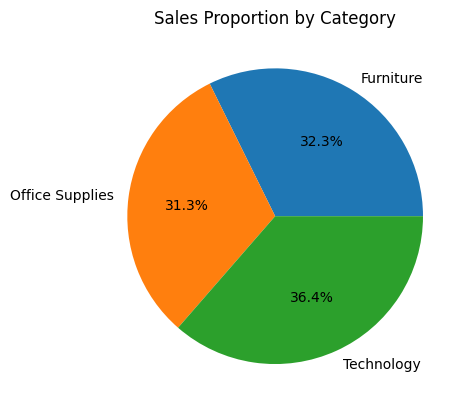

In [10]:
category_sales = data.groupby("Category")["Sales"].sum()

title = "Sales Proportion by Category"
plot_piechart(category_sales.values, category_sales.index, title)

As we can see, the Technology category is accounted for the highest sales amount. However, the overall distribution seems quite uniform. That is, each category has approximately an equal total sales amount.


Now, let us compare the sales distribution with the profit distribution:

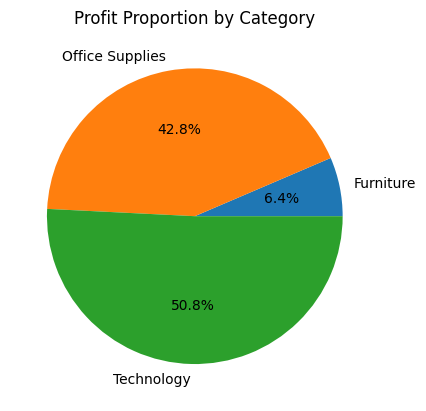

In [11]:
category_profit = data.groupby("Category")["Profit"].sum()

title = "Profit Proportion by Category"
plot_piechart(category_profit.values, category_profit.index, title)

As we can see, this plot revels a completely different story:

- Although the Furniture category has approximately the same total sales as the other categories, it only accounts for ~6% of the total profit.
- The Technology and Office Supplies categories account for over 93% of the total profit, with roughly same proportion (~51% and ~43% respectively).

#### Product Sub-Categories

First, let us rank the different sub-categories based on their total sales:

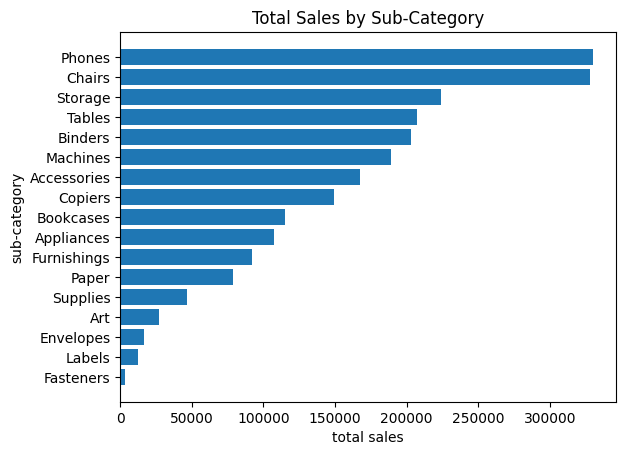

In [12]:
sub_categories_sales = data.groupby("Sub-Category")["Sales"].sum().sort_values()

title = "Total Sales by Sub-Category"
x_label = "total sales"
y_label = "sub-category"
plot_horizontal_barchart(sub_categories_sales.index, sub_categories_sales.values,
                         title, x_label, y_label)

From the plot above we can conclude the following:

- Both the Phones and Chairs sub-categories have the highest total sales amount.
- The values' decrease is relatively rapid. However, each sub-category has some sales amount.

Now, let us rank the sub-categories based on their profit-sales ratio:

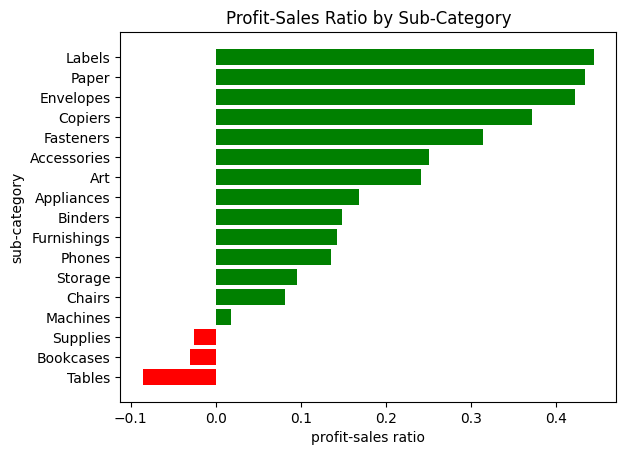

In [13]:
sub_categories_profit_sales_ratio = data.groupby("Sub-Category")\
                            .apply(lambda x: x["Profit"].sum() / x["Sales"].sum())\
                            .sort_values()

title = "Profit-Sales Ratio by Sub-Category"
x_label = "profit-sales ratio"
y_label = "sub-category"
colors = ["green" if x > 0 else "red" for x in sub_categories_profit_sales_ratio.values]
plot_horizontal_barchart(sub_categories_profit_sales_ratio.index, sub_categories_profit_sales_ratio.values,
                         title, x_label, y_label, colors=colors)


From the plot above we can conclude the following:

- Although the Labels sub-category is the second to last w.r.t. total sales, it has the highest profit-sales ratio, with a ratio of 0.4. That is, 40% of the entire sales of products under this sub-category is profit.
- Although the Phones sub-category has the highest total sales, it is only the 11th highest profit-sales ratio sub-category (but with a positive ratio).
- The following sub-categories have a negative profit-sales ratio, and hence a **negative profit**: Supplies, Bookcases, Tables.  

Let us further explore the negative profit sub-categories by finding the following for each one: 

- Product IDs of the negative profit products.
- Number of negative profit products.
- Negative profit products' proportion among all the sub-category's unique products.

In [14]:
neg_sub_categories = ["Supplies", "Bookcases", "Tables"]

for sub_category in neg_sub_categories:
    df = data[data["Sub-Category"] == sub_category].groupby("Product ID")["Profit"].sum()
    neg_percent = len(df[df < 0]) / len(df) * 100
    neg_products = list(df[df < 0].index)
    
    print(f"--------{sub_category} Sub-Category--------\n")
    print(f"Negative profit products: \n{neg_products}\n")
    print(f"Number of negative profit products: {len(neg_products)}")
    print(f"Negative profit products percentage: {neg_percent:.2f}%\n\n")
    

--------Supplies Sub-Category--------

Negative profit products: 
['OFF-SU-10000151', 'OFF-SU-10000157', 'OFF-SU-10000432', 'OFF-SU-10000646', 'OFF-SU-10001225', 'OFF-SU-10001935', 'OFF-SU-10002189', 'OFF-SU-10002301', 'OFF-SU-10002881', 'OFF-SU-10003505', 'OFF-SU-10003567', 'OFF-SU-10003936', 'OFF-SU-10004498']

Number of negative profit products: 13
Negative profit products percentage: 34.21%


--------Bookcases Sub-Category--------

Negative profit products: 
['FUR-BO-10000112', 'FUR-BO-10000468', 'FUR-BO-10000780', 'FUR-BO-10001337', 'FUR-BO-10001567', 'FUR-BO-10001601', 'FUR-BO-10001608', 'FUR-BO-10001798', 'FUR-BO-10001918', 'FUR-BO-10001972', 'FUR-BO-10002202', 'FUR-BO-10002206', 'FUR-BO-10002268', 'FUR-BO-10002613', 'FUR-BO-10002853', 'FUR-BO-10003034', 'FUR-BO-10003159', 'FUR-BO-10003272', 'FUR-BO-10003433', 'FUR-BO-10003450', 'FUR-BO-10003546', 'FUR-BO-10003893', 'FUR-BO-10003965', 'FUR-BO-10003966', 'FUR-BO-10004218', 'FUR-BO-10004357', 'FUR-BO-10004360', 'FUR-BO-10004409', 

**For the Supplies sub-category:**

- The products with negative profit are (13):
    
  'OFF-SU-10000151', 'OFF-SU-10000157', 'OFF-SU-10000432', 'OFF-SU-10000646', 'OFF-SU-10001225', 'OFF-SU-10001935', 'OFF-SU-10002189', 'OFF-SU-10002301', 'OFF-SU-10002881', 'OFF-SU-10003505', 'OFF-SU-10003567', 'OFF-SU-10003936', 'OFF-SU-10004498'

- These products are ~34% of the entire sub-category. That is, 34% of the sub-category's products have negative profit.

**For the Bookcases sub-category:**

- The products with negative profit are (32):

    'FUR-BO-10000112', 'FUR-BO-10000468', 'FUR-BO-10000780', 'FUR-BO-10001337', 'FUR-BO-10001567', 'FUR-BO-10001601', 'FUR-BO-10001608', 'FUR-BO-10001798', 'FUR-BO-10001918', 'FUR-BO-10001972', 'FUR-BO-10002202', 'FUR-BO-10002206', 'FUR-BO-10002268', 'FUR-BO-10002613', 'FUR-BO-10002853', 'FUR-BO-10003034', 'FUR-BO-10003159', 'FUR-BO-10003272', 'FUR-BO-10003433', 'FUR-BO-10003450', 'FUR-BO-10003546', 'FUR-BO-10003893', 'FUR-BO-10003965', 'FUR-BO-10003966', 'FUR-BO-10004218', 'FUR-BO-10004357', 'FUR-BO-10004360', 'FUR-BO-10004409', 'FUR-BO-10004467', 'FUR-BO-10004690', 'FUR-BO-10004709', 'FUR-BO-10004834'

- These products are ~65% of the entire sub-category.

**For the Tables sub-category:**

- The products with negative profit are (43):

    'FUR-TA-10000198', 'FUR-TA-10000577', 'FUR-TA-10000849', 'FUR-TA-10001039', 'FUR-TA-10001095', 'FUR-TA-10001520', 'FUR-TA-10001539', 'FUR-TA-10001676', 'FUR-TA-10001768', 'FUR-TA-10001857', 'FUR-TA-10001866', 'FUR-TA-10001889', 'FUR-TA-10001932', 'FUR-TA-10001950', 'FUR-TA-10002041', 'FUR-TA-10002228', 'FUR-TA-10002356', 'FUR-TA-10002530', 'FUR-TA-10002533', 'FUR-TA-10002607', 'FUR-TA-10002622', 'FUR-TA-10002645', 'FUR-TA-10002774', 'FUR-TA-10002903', 'FUR-TA-10002958', 'FUR-TA-10003008', 'FUR-TA-10003238', 'FUR-TA-10003469', 'FUR-TA-10003473', 'FUR-TA-10003715', 'FUR-TA-10003837', 'FUR-TA-10003954', 'FUR-TA-10004086', 'FUR-TA-10004152', 'FUR-TA-10004154', 'FUR-TA-10004175', 'FUR-TA-10004256', 'FUR-TA-10004289', 'FUR-TA-10004442', 'FUR-TA-10004534', 'FUR-TA-10004575', 'FUR-TA-10004607', 'FUR-TA-10004915'

- These products are ~75% of the entire sub-category.

Note that although the Supplies sub-category has a relative low negative profit products percentage (compared to the rest), it still has an overall negative profit. That is, the negative profit of approximately 1/3 of the sub-category's products shadows the positive profit of nearly double the number of products.




Let us continue to explore the Supplies sub-category by finding the total sales proportion of the negative profit products compare to the one of the positive profit products:  

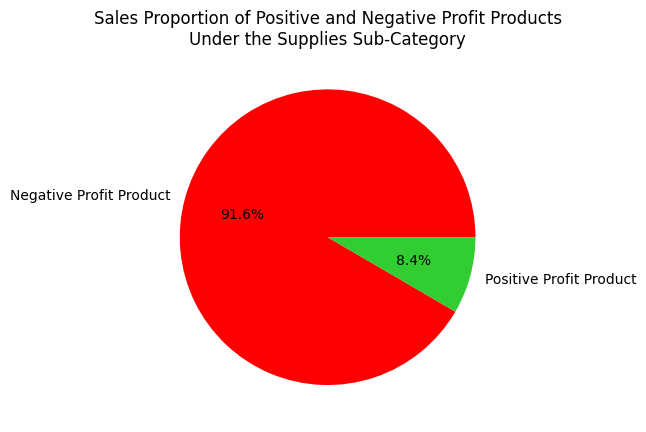

In [15]:
df = data[data["Sub-Category"] == "Supplies"].groupby("Product ID")[["Sales", "Profit"]].sum().reset_index()
# label the products based on their profit sign
df["Profit Sign"] = df["Profit"].apply(lambda x: "Positive Profit Product" if x > 0 else "Negative Profit Product")
df = df.groupby("Profit Sign")["Sales"].sum()

title = "Sales Proportion of Positive and Negative Profit Products\nUnder the Supplies Sub-Category"
plot_piechart(df.values, df.index, title, colors=["red", "limegreen"])

As we can see, although the negative profit products accounts for only a 1/3 of the entire products under this category, their total sales proportion is over 90%. That is, the number of negative profit products under this sub-category is not large, but these products are very successful. This insight clearly explains the negative profit of the Supplies sub-category. 

A reasonable explanation for this phenomenon is that the store sell these products at an extremely low price. This price driveup sales in the sub-category, but causes the store to lose money on them.

#### Products

First, let us find the top 10 best-selling products (w.r.t. total quantity sold):

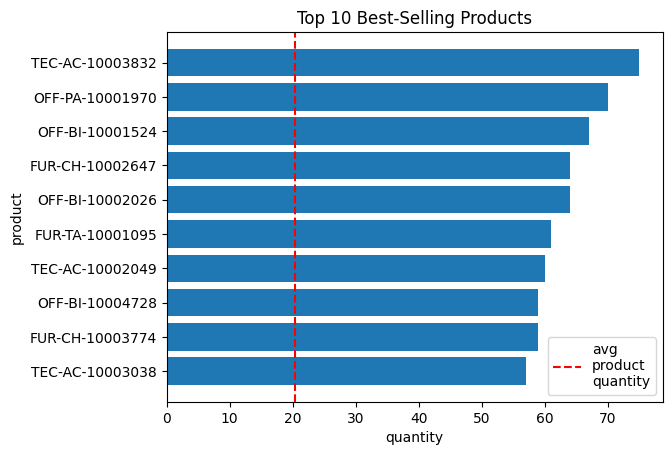

In [16]:
products_quantity = data.groupby("Product ID")["Quantity"].sum().sort_values(ascending=False)

top_products = list(products_quantity.index[:10])
top_quantity = list(products_quantity.values[:10])

top_products.reverse()
top_quantity.reverse()
avg_quantity = products_quantity.mean()

title = "Top 10 Best-Selling Products"
x_label = "quantity"
y_label = "product"
plot_horizontal_barchart(top_products, top_quantity, title, x_label, y_label,
                         vline=avg_quantity, vline_label="avg\nproduct\nquantity")

From the plot above we can conclude the following:

- The best-selling product is 'TEC-AC-10003832' (Logitech Mobile Speakerphone), with total quantity sold of 70+.
- All the best-selling products are well above the mean quantity (roughly 3x bigger).
- The values' decrease is quite moderate.

Now, let us find the top 10 products with the highest total sales:

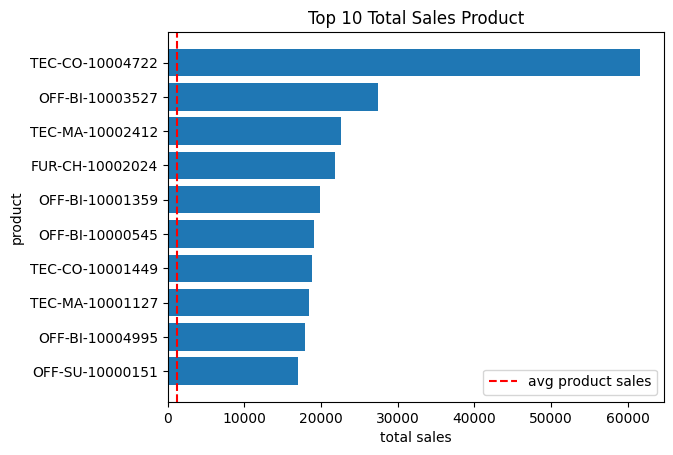

In [17]:
products_sales = data.groupby("Product ID")["Sales"].sum().sort_values(ascending=False)

top_products = list(products_sales.index[:10])
top_sales = list(products_sales.values[:10])

top_products.reverse()
top_sales.reverse()
avg_sales = products_sales.mean()

title = "Top 10 Total Sales Product"
x_label = "total sales"
y_label = "product"
plot_horizontal_barchart(top_products, top_sales, title, x_label, y_label,
                         vline=avg_sales, vline_label="avg product sales")

From the plot above we can conclude the following:

- The top total sales product is 'TEC-CO-10004722' (High Speed Automatic Electric Letter Opener), and by far. In addition, it accounts for nearly 3% of the store's entire sales. This insight is quite impressive given the fact that the store offers more than 1800 unique products.
- The top 10 products total sales are extremely higher than the average product sales. This insight implies a high variance.
- The values' decrease from the first to the second-highest sales product is extremely rapid. However, from the second-highest sales product onwards, the decline is much more subtle.

Now, let us compare the top 10 highest sales products with the top 10 highest profit-sales ratio products:

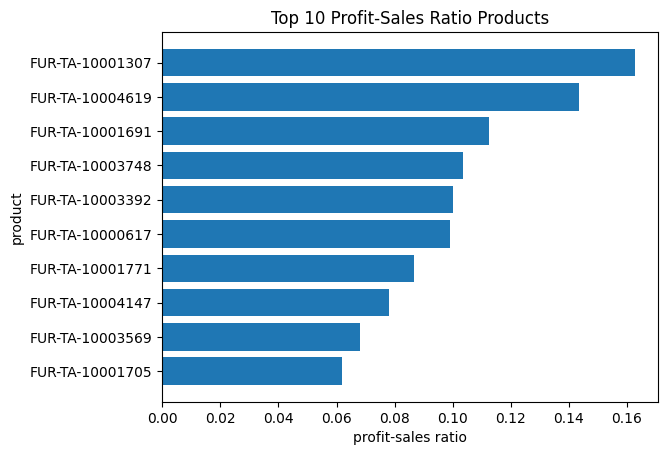

In [18]:
products_profit_sales_ratio = data[data["Sub-Category"] == "Tables"].groupby("Product ID")\
                                                                        .apply(lambda x: x["Profit"].sum() / x["Sales"].sum())\
                                                                        .sort_values(ascending=False)\

top_products = list(products_profit_sales_ratio.index[:10])
top_profit_sales_ratio = list(products_profit_sales_ratio.values[:10])

top_products.reverse()
top_profit_sales_ratio.reverse()

title = "Top 10 Profit-Sales Ratio Products"
x_label ="profit-sales ratio"
y_label = "product"
plot_horizontal_barchart(top_products, top_profit_sales_ratio, title, x_label, y_label)

From the graph above we can conclude the following:

- The product with the highest profit-sales ratio is 'FUR-TA-10001307' (SAFCO PlanMaster Heigh-Adjustable Drafting Table Base, 43w x 30d x 30-37h, Black), with a ratio of ~0.16.
- The top 10 highest profit-sales ratio products are completely different from the top 10 highest sales products.
- The values' decrease is quite moderate.

Now, let us find the negative profit products:

In [19]:
products_profit = data.groupby("Product ID")["Profit"].sum()
products_neg_profit = products_profit[products_profit < 0]

neg_profit_products_num = len(products_neg_profit)
neg_profit_products_percent = neg_profit_products_num / len(products_profit) * 100

print(f"Total number of unique products with negative profit: {neg_profit_products_num}")
print(f"Percent of products with negative profit: {neg_profit_products_percent:.2f}%")
print()
print("Negative profit products:")
print(list(products_neg_profit.index))


Total number of unique products with negative profit: 301
Percent of products with negative profit: 16.17%

Negative profit products:
['FUR-BO-10000112', 'FUR-BO-10000468', 'FUR-BO-10000780', 'FUR-BO-10001337', 'FUR-BO-10001567', 'FUR-BO-10001601', 'FUR-BO-10001608', 'FUR-BO-10001798', 'FUR-BO-10001918', 'FUR-BO-10001972', 'FUR-BO-10002202', 'FUR-BO-10002206', 'FUR-BO-10002268', 'FUR-BO-10002613', 'FUR-BO-10002853', 'FUR-BO-10003034', 'FUR-BO-10003159', 'FUR-BO-10003272', 'FUR-BO-10003433', 'FUR-BO-10003450', 'FUR-BO-10003546', 'FUR-BO-10003893', 'FUR-BO-10003965', 'FUR-BO-10003966', 'FUR-BO-10004218', 'FUR-BO-10004357', 'FUR-BO-10004360', 'FUR-BO-10004409', 'FUR-BO-10004467', 'FUR-BO-10004690', 'FUR-BO-10004709', 'FUR-BO-10004834', 'FUR-CH-10000225', 'FUR-CH-10000229', 'FUR-CH-10000513', 'FUR-CH-10000863', 'FUR-CH-10001190', 'FUR-CH-10001482', 'FUR-CH-10001545', 'FUR-CH-10001714', 'FUR-CH-10001973', 'FUR-CH-10002044', 'FUR-CH-10002126', 'FUR-CH-10002372', 'FUR-CH-10002880', 'FUR-CH-10

As we can see, the store sells ~300 unique products with an overall negative profit.

These products are ~16% of the entire products that the store offers.

### Geographic

In this section, we will analyze the orders' geographical attributes by various aspects.

#### Regions

First, let us find the total sales proportion in each region:

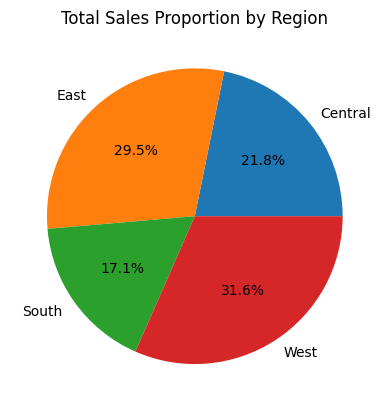

In [20]:
region_sales = data.groupby("Region")["Sales"].sum()

title = "Total Sales Proportion by Region"
plot_piechart(region_sales.values, region_sales.index, title)

From the Plot above we can conclude the following:

- The West and East regions account for the majority of the total sales (over 60%) with proportions of ~32% and ~30% respectively.
- The South region accounts for the lowest proportion of the total sales.

Now, let us compare the sales distribution with the distribution of the total number of customers:

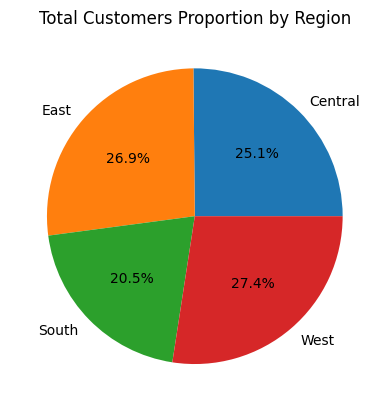

In [21]:
region_customers = data.groupby("Region")["Customer ID"].apply(lambda x: x.nunique())

title = "Total Customers Proportion by Region"
plot_piechart(region_customers.values, region_customers.index, title)

As we can see, the relative order of the regions' proportions remained the same. However, the distribution appears to be much more uniform.



Now, let us compare the sales distribution with the profit distribution:

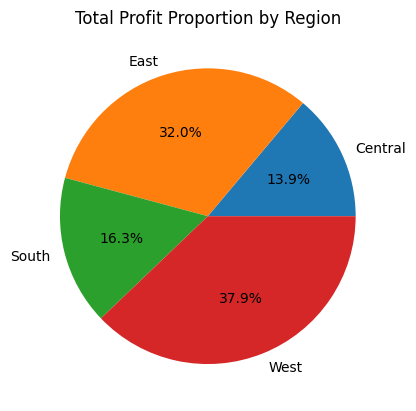

In [22]:
region_profit = data.groupby("Region")["Profit"].sum()

title = "Total Profit Proportion by Region"
plot_piechart(region_profit.values, region_profit.index, title)

From the plot above we can see that there is a slight shift in the distribution:

- the West and East regions remained with the highest and second-highest proportions respectively. However, their difference increased. As a result, we can conclude that the products sold in the West region are more profitable.
- Although the South region has a lower total sales proportion than the Central region, it has a higher profit proportion. hence, we can conclude that the products sold in the South region are much more profitable.

In [23]:
def find_avg_shipping_time(df):
    # drop records with the same order ID
    df = df.drop_duplicates(subset=["Order ID"])
    # calculate the total time shipping time of all the orders
    total_shipping_time = (df["Ship Date"] - df["Order Date"]).dt.days.sum()
    # calculate the total number of orders
    total_orders_num = len(df)
    # calculate the average order shipping time
    avg_shipping_time = total_shipping_time / total_orders_num
    
    return avg_shipping_time

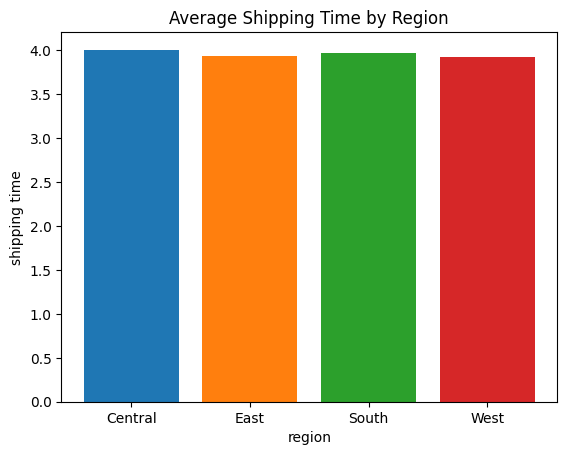

In [24]:
region_shipping_time = data.groupby("Region").apply(find_avg_shipping_time)

title = "Average Shipping Time by Region"
x_label = "region"
y_label = "shipping time"
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
plot_vertical_barchart(region_shipping_time.index, region_shipping_time.values,
                       title, x_label, y_label, colors=colors)

As we can see, the shipping time in uniform across the different regions, with an average time of  ~4 days.

#### States

First, let us rank the states by their total sales:

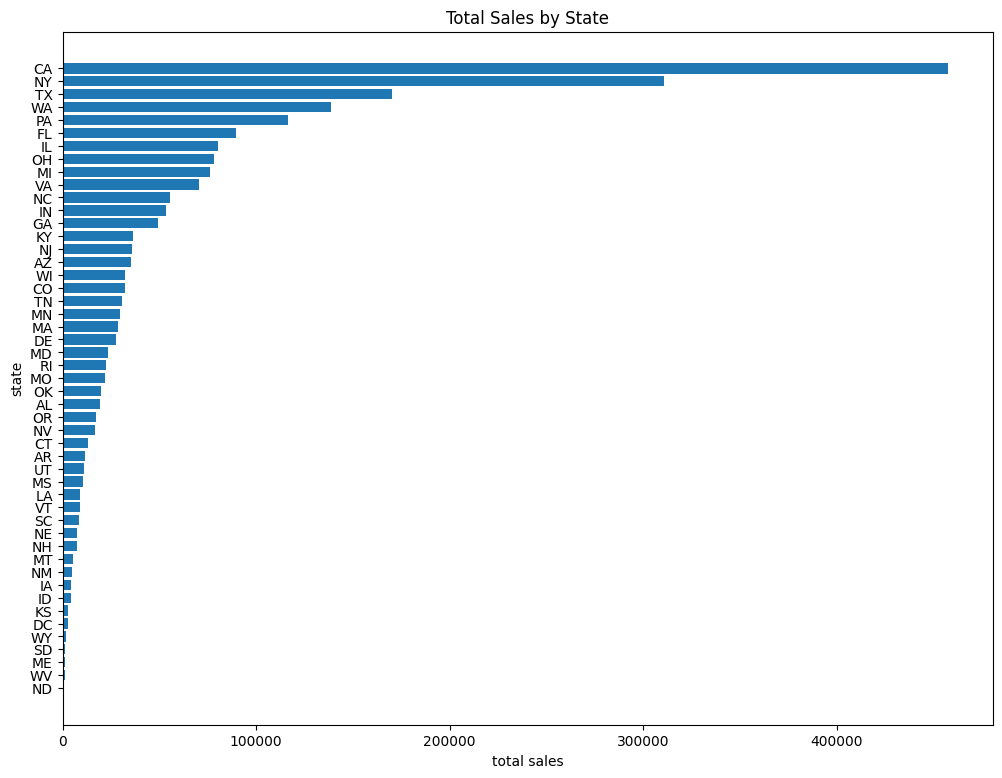

In [25]:
states_sales = data.groupby("State")["Sales"].sum().sort_values()

title = "Total Sales by State"
x_label = "total sales"
y_label = "state"
plot_horizontal_barchart(states_sales.index, states_sales.values, title, x_label, y_label, figsize=(12, 9))

From the plot above we can conclude the following:

- The state with the highest total sales in California, and by far.
- Roughly 20% of the states have a negligible total sales amount (<10k, which is less the 1% of the total sales).
- The values' decrease is quite rapid.

Now, let us rank the states by their discount-sales ratio:

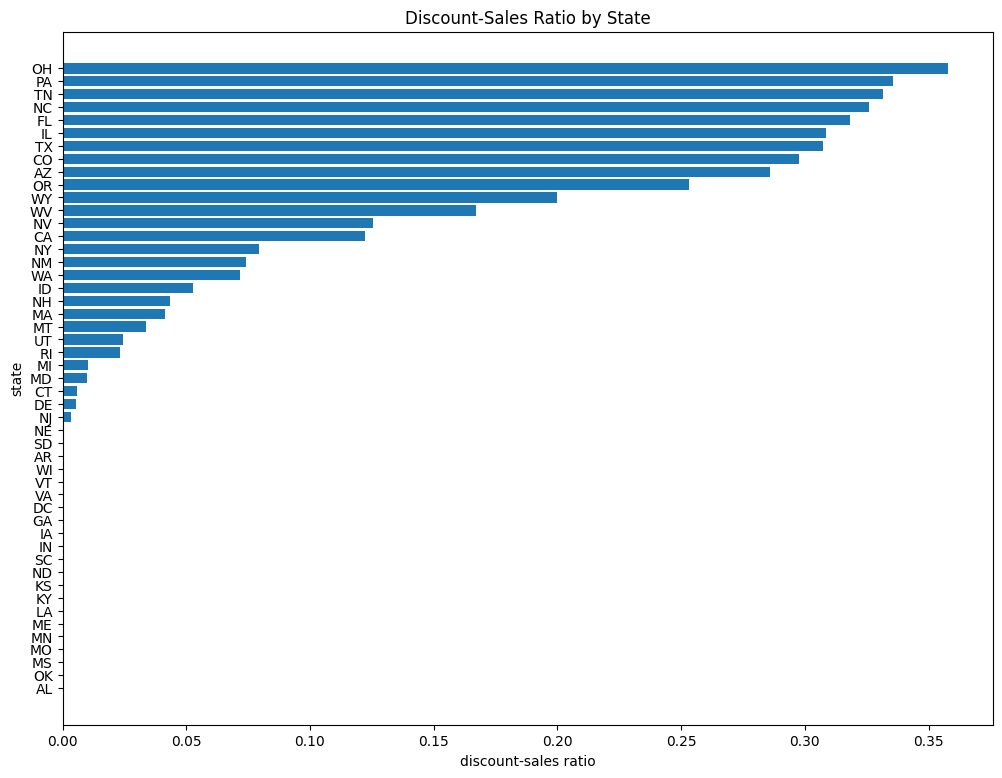

In [26]:
states_discount_sales_ratio = data.groupby("State")\
                                  .apply(lambda x:x["Discount Amount"].sum() / x["Sales"].sum())\
                                  .sort_values()

title = "Discount-Sales Ratio by State"
x_label = "discount-sales ratio"
y_label = "state"
plot_horizontal_barchart(states_discount_sales_ratio.index, states_discount_sales_ratio.values,
                         title, x_label, y_label, figsize=(12, 9))

From the plot above we can conclude the following:

- Ohio has the highest discount/sales ratio, with a ratio of 0.35. That is, 35% of the state's total sales will be discounted.
- Roughly 40% of the stats do not have any discount amount.
- The values' decrease is quite rapid, even more than the previous plot.

Now, let us rank the states by their profit-sales ratio:

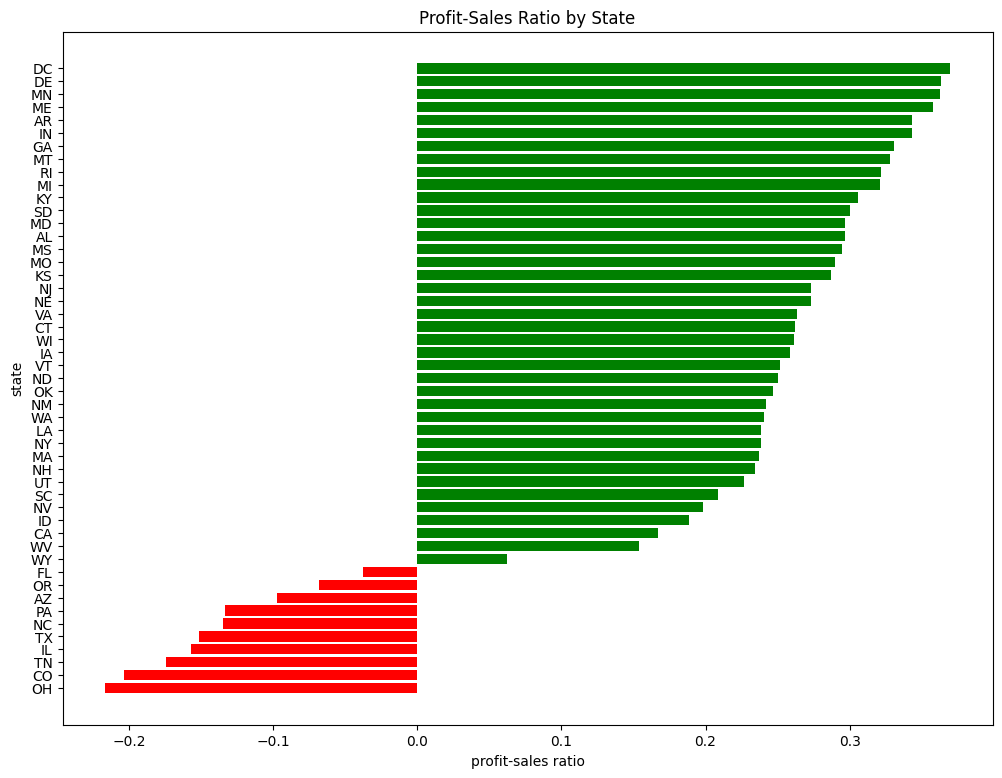

In [27]:
states_profit_sales_ratio = data.groupby("State")\
                                  .apply(lambda x:x["Profit"].sum() / x["Sales"].sum())\
                                  .sort_values()

title = "Profit-Sales Ratio by State"
x_label = "profit-sales ratio"
y_label = "state"
colors = ["green" if x > 0 else "red" for x in states_profit_sales_ratio.values]
plot_horizontal_barchart(states_profit_sales_ratio.index, states_profit_sales_ratio.values,
                         title, x_label, y_label, colors=colors, figsize=(12, 9))

From the plot above we can conclude the following:

- There are 10 different states with a **negative** profit-sales ratio:  Florida, Oregon, Arizona, Pennsylvania, North Carolina, Texas, Illinois, Tennessee, Colorado and Ohio. That is, for each dollar spent in those states, the store losses money. These states account for 20% of the entire states that the store sells in. 
- The 10 negative profit-sales ratio states are the top 10 states with the highest discount-sales ratio.
- Ohio is the State with the highest negative profit-sales ratio, with a ratio of ~-0.2. That is, the store losses 20% of the entire sales in this state. Note that Ohio has the highest discount-sales ratio.
- District of Columbia has the highest profit-sales ratio, with a ratio of ~0.35. 

Lastly, let us rank the states by their average order shipping time:

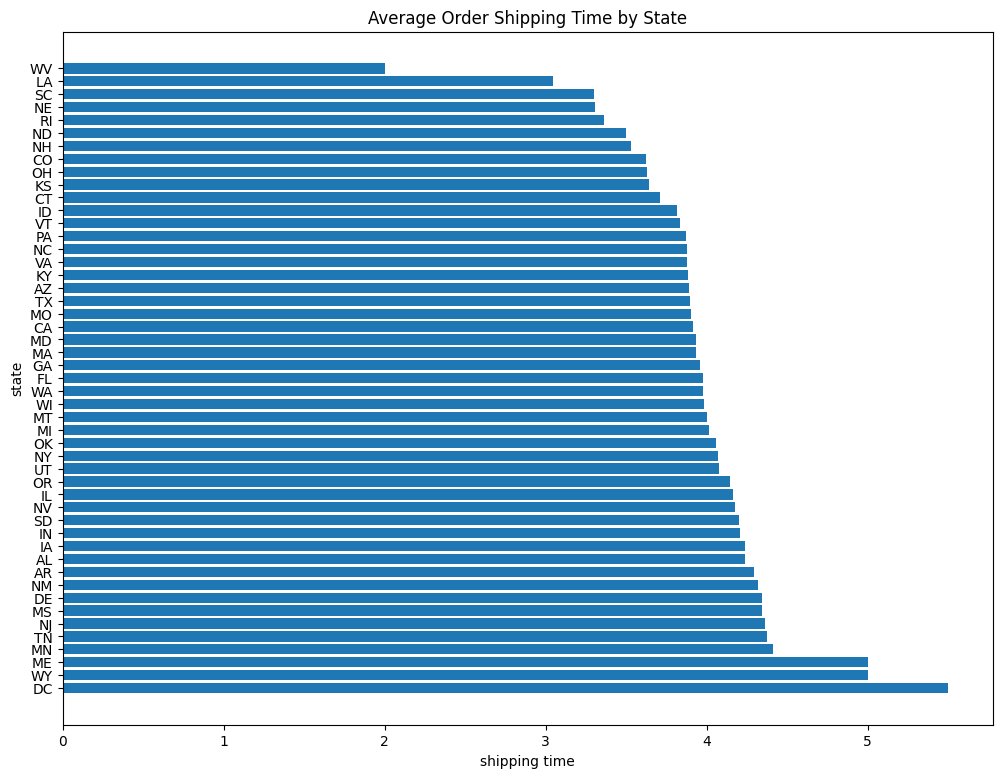

In [28]:
state_shipping_time = data.groupby("State").apply(find_avg_shipping_time).sort_values(ascending=False)

title = "Average Order Shipping Time by State"
x_label = "shipping time"
y_label = "state"
plot_horizontal_barchart(state_shipping_time.index, state_shipping_time.values,
                         title, x_label, y_label, figsize=(12, 9))

From the plot above we can conclude the following:

- West Virginia has the lowest average shipping time, of 2 days.
- District of Colombia has the highest average shipping time, of more than 5 days. Note that is value is more than double the value of West Virginia.
- The Majority of stats have an average shipping time of 3-4 days.

### Customers

In this section we will analyze the customer segments by various aspects.

First, let us find the sales proportion and profit proportion of each customer segment:

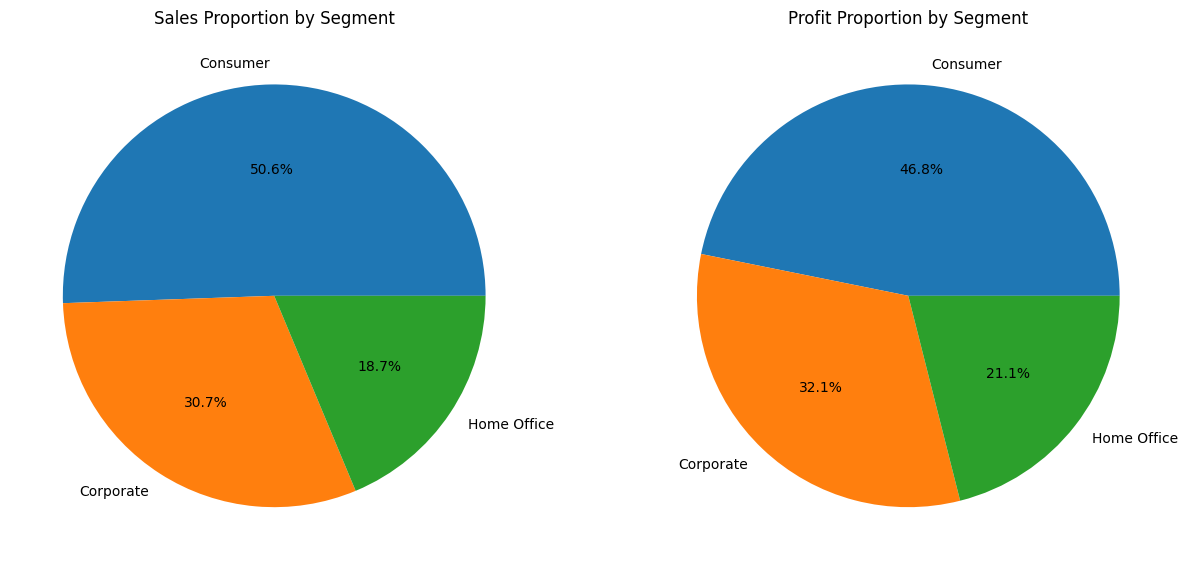

In [29]:
segment_sales = data.groupby("Segment").agg({"Sales": "sum",
                                             "Profit": "sum",})

fig, axs = plt.subplots(1, 2, figsize=(15, 9))

axs[0].pie(segment_sales["Sales"], labels=segment_sales.index, autopct='%1.1f%%')
axs[0].set_title('Sales Proportion by Segment')

axs[1].pie(segment_sales["Profit"], labels=segment_sales.index, autopct='%1.1f%%')
axs[1].set_title("Profit Proportion by Segment")

plt.show()

From the graphs above we can conclude the following:

Sales graph:
- The Consumer segment has the highest sales proportion, and it accounts for more than 50% of the store's total sales.
- The Corporate segment has the second-highest proportion of ~31%, which is nearly double the one of the Home Office segment.

Profit graph:
- The Consumer segment has the highest profit proportion, with nearly 50% of the entire profit.
- The Consumer segment is the only one where the profit proportion is lower than the sales proportion. Therefore, we can conclude that customers under this segment buy less profitable products.

In general, the two plots appears to be overall consistent with one another.

Now, let us compare the profit-sales ratio of each of the segments:

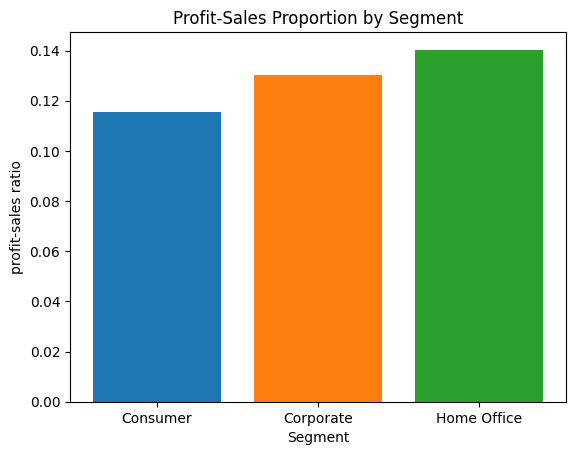

In [30]:
segment_profit_sales_ratio = data.groupby("Segment").apply(lambda x: x["Profit"].sum() / x["Sales"].sum())

plt.bar(segment_profit_sales_ratio.index, segment_profit_sales_ratio.values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Profit-Sales Proportion by Segment")
plt.xlabel("Segment")
plt.ylabel("profit-sales ratio")
plt.show()

From the following plot we can conclude the following:

- The overall distribution seems quite uniform.
- The Home Office segment has the highest profit-sales ratio, but the difference is small.
- Each customer segment has a positive profit-sales ratio.

### Time

In this section we will analyze the time dimension of the data.

Note that the data contains daily records. In order to smooth the values, we will focus on a monthly time period by aggregating the values.

First, let us find the total sales and total profit by month and compare the two:

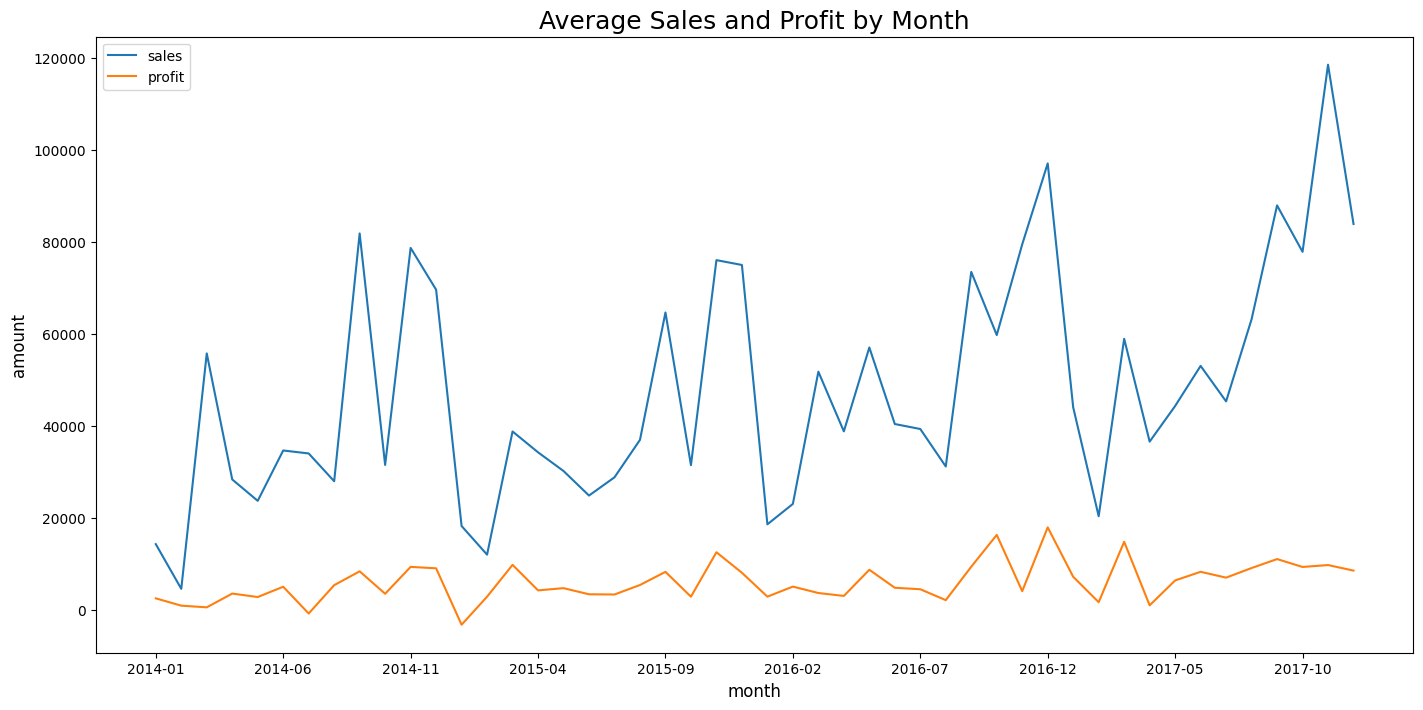

In [31]:
month_df = data.groupby("Order Month").agg({"Sales": "sum",
                                                "Profit": "sum"})
dates = [str(x) for x in month_df.index]
avg_sales = month_df["Sales"].mean()
avg_profit = month_df["Profit"].mean()

plt.figure(figsize=(17, 8))
plt.plot(dates, month_df["Sales"], label="sales")
plt.plot(dates, month_df["Profit"], label="profit")
plt.title("Average Sales and Profit by Month", fontsize=18)
plt.xlabel("month", fontsize=12)
plt.ylabel("amount", fontsize=12)
plt.xticks(ticks=[i for i in range(0, len(dates), 5)])
plt.legend()
plt.show()

From the above plot we can conclude the following:

- There is high positive correlation between the two. In other words, in months with a increase in sales we can also see a increase in profit (in the same months), and vise verse.
- There is an upward trend in both sales and profit.
- There is a yearly seasonality in both sales and profit, and with higher presents in sales.  In particular, the sales at the start of the year (January-February) is very low. Then, there is a some degree of steady increase which peaks at November-December. Finally, there is a massive decrease at the start of the next year.
- The sales' variance is quite large. In contrast, the profit's variance is much more subtle.


Now, let us break down the total number of orders by month:

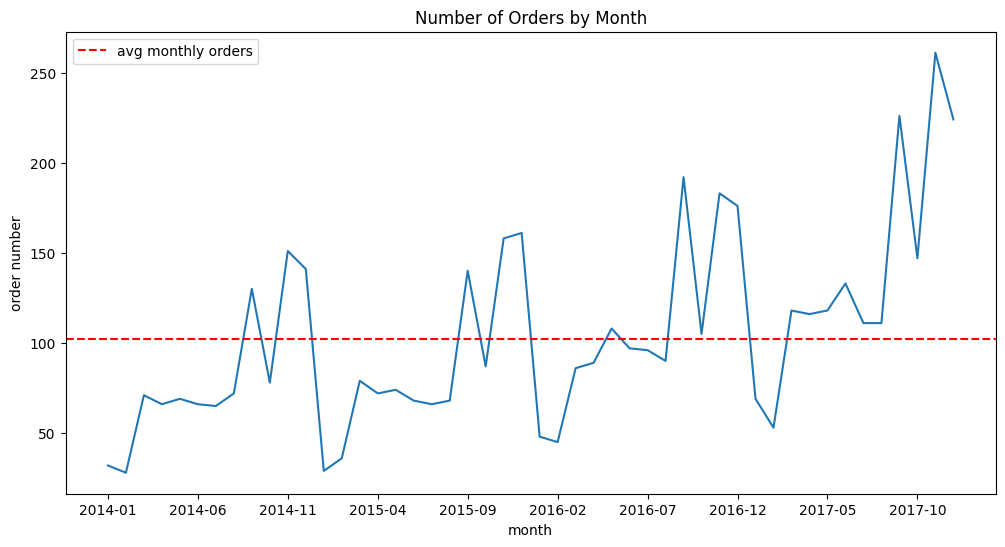

In [32]:
month_df = data.groupby("Order Month").apply(lambda x: x["Order ID"].nunique())
dates = [str(x) for x in month_df.index]
avg_order_month = total_orders / total_months

title = "Number of Orders by Month"
x_label = "month"
y_label = "order number"

plot_lineplot(dates, month_df.values, title, x_label, y_label,
              hline=avg_order_month, hline_label="avg monthly orders",
              figsize=(12, 6), x_ticks=[i for i in range(0, len(dates), 5)])

From the following plot we can conclude the following:

- There is a yearly seasonality associated with the number of orders. This seasonality highly correlates with the sales seasonality.
- There is an overall upward trend in the number of orders. That is, the number of orders in a given month is increasing from year to year. This phenomenon is especially present at the 4th year (2017).

## RFM Customer Segmentation

In this section, we would like to cluster the customers into various common groups.

As known, a commonly used clustering method is the K-Means algorithm. However, the resulting clusters are not quite interpretable.

As a result, we will use RFM customer segmentation:

- Recency - days since the last purchase.

- Frequency - total number of orders.

- Monetary - total amount spent.

This segmentation method allows us to clearly define, control and interpret the different customer labels.

### Segmentation Definition

First, let us calculate each customer's rank with respect to each of the RFM components:

In [33]:
ref_date = data["Order Date"].max() + dt.timedelta(days=1)

rfm = data.groupby("Customer ID").agg({"Order Date": lambda x: (ref_date - x.max()).days,
                                         "Order ID": lambda x: x.nunique(),
                                         "Sales": lambda x: x.sum()})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.reset_index(inplace=True)

rfm["R_rank"] = pd.qcut(rfm["Recency"], 4, [1, 2, 3, 4])
rfm["F_rank"] = pd.qcut(rfm["Frequency"], 4, [4, 3, 2, 1])
rfm["M_rank"] = pd.qcut(rfm["Monetary"], 4, [4, 3, 2, 1])

rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank
0,AA-10315,185,5,5563.560,4,4,1
1,AA-10375,20,9,1056.390,1,1,4
2,AA-10480,260,4,1790.512,4,4,3
3,AA-10645,56,6,5086.935,2,3,1
4,AB-10015,416,3,886.156,4,4,4


Now, we will need to define the various customer labels.

Note that this definition process contains a major trade-off: on the one hand, we want the groups to be as specific as possible in order for us to best understand each group's characteristics. On the other hand, we want the groups to be as broad as possible in order to minimize the total number of different groups (which will help us in the analysis phase).

In addition, we will need to define the groups such that all  customers will belong to some group.

After careful consideration, we will define the following labels:

1. Champions:

    - Profile - R_rank = 1, F_rank = 1, M_rank = 1.
    - Description - these customers are the best ones. They buy the most frequently, spend the most, and have purchased very recently. They are highly engaged and the most valuable.

2. Loyal:

    - Profile - R_rank = 1 or 2, F_rank = 1 or 2, M_rank = 1 or 2.
    - Description - these customers are consistent buyers. They are satisfied and loyal, though they may not always spend as much as Champions.

3. Potential Loyalists:

    - Profile - R_rank = 1 or 2 and [(F_rank = 1 or 2, M_rank = 2, 3 or 4) or (F_rank = 2, 3 or 4, M_rank = 1 or 2)].
    - Description - these customers are consistent buyers, however their purchases are moderate (w.r.t. the total number of purchases or the total amount spent). They show promise to become loyal customers with further engagement.

4. New:

    - Profile - R_rank = 1, F_rank = 3 or 4, M_rank = 3 or 4.
    - Description - these are new customers who made their first purchase recently. They need encouragement to repeat purchases and build loyalty.

5. Can't Lose Them:

    - Profile - R_rank = 3 or 4, F_rank = 1 or 2, M_rank = 1 or 2.
    - Description - these are valuable customers in the past, but they haven’t purchased in a long time. They require immediate attention to win them back.

6. One-Time Big Spenders

    - Profile - R_rank = 1, 2, 3, or 4, F_rank = 3, 4, M_rank = 1, 2
    - Description - these are customers who spent a large amount over small number of orders.

7. Bargain Hunters

    - Profile - R_rank = 1, 2, 3 or 4, F_rank = 1 or 2, M_rank = 3 or 4
    - Description - these are customers who made a lot of orders but spent a small amount.

8. Low-Value:

    - Profile - R_rank = 3 or 4, F_rank = 3 or 4, M_rank = 3 or 4.
    - Description - These customers have the lowest scores across all metrics. They purchase infrequently, haven’t spent much, and haven’t bought recently. They might not be worth significant marketing effort.

*Any customers which do not belong to any of the above groups will be labeled as Other. Our goal is to minimize this group size, since it is not interpretable.


Now, let us find each customer's label (according to the definitions above):

In [34]:
def label_customer(row):
    
    label = "Other"
    
    if row['R_rank'] == 1 and row['F_rank'] == 1 and row['M_rank'] == 1:
         label = "Champions"
    
    elif row['R_rank'] in (1, 2) and row['F_rank'] in (1, 2) and row['M_rank'] in (1, 2):
        label = "Loyal"
    
    elif row['R_rank'] in (1, 2) and \
        ((row['F_rank'] in (1, 2) and row['M_rank'] in (2, 3, 4)) or (row['F_rank'] in (2, 3, 4) and row['M_rank'] in (1, 2))):
        label = "Potential Loyalists"
        
    elif row['R_rank'] in (1, 2) and row['F_rank'] in (3, 4) and row['M_rank'] in (3, 4):
        label = "New"
    
    elif row['R_rank'] in (3, 4) and row['F_rank'] in (1, 2) and row['M_rank'] in (1, 2):
        label = "Can't Lose Them"
        
    elif row['R_rank'] in (1, 2, 3, 4) and row['F_rank'] in (3, 4) and row['M_rank'] in (1, 2):
        label =  "One-Time Big Spenders"
        
    elif row['R_rank'] in (1, 2, 3, 4) and row['F_rank'] in (1, 2) and row['M_rank'] in (3, 4):
        label =  "Bargain Hunters"
    
    elif row['R_rank'] in (3, 4) and row['F_rank'] in (3, 4) and row['M_rank'] in (3, 4):
        label = "Low-Value"
    
    return label

In [35]:
rfm["Customer Label"] = rfm.apply(label_customer, axis=1)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,Customer Label
0,AA-10315,185,5,5563.560,4,4,1,One-Time Big Spenders
1,AA-10375,20,9,1056.390,1,1,4,Potential Loyalists
2,AA-10480,260,4,1790.512,4,4,3,Low-Value
3,AA-10645,56,6,5086.935,2,3,1,Potential Loyalists
4,AB-10015,416,3,886.156,4,4,4,Low-Value


Now, let us find the label distribution:

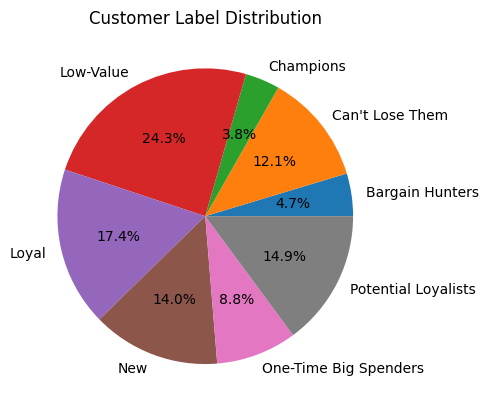

In [36]:
customer_labels_cnt = rfm.groupby("Customer Label")["Customer ID"].apply(lambda x: x.nunique())

title = "Customer Label Distribution"
plot_piechart(customer_labels_cnt.values, customer_labels_cnt.index, title)

As we can see, our defined labels managed to cover all the customers. That is, no customer was assigned the Other label. In addition, we managed to do so by only defining 8 distinct groups.

Moreover, from the plot above we can conclude the following:

- The Champions customers are only ~4% of the entire customers. However, note that this label is very exclusive (top rank at all RFM metrics). Thus, is proportion is quite high.
- Approximately 17% of the customers are Loyal. Hence, the store has quite a large proportion of engaged customers.
- roughly 15% of the customers are Potential Loyalists. As a result, there is a substantial proportion of customers that can be converted to Loyal ones with the right strategy.
- More that 10% of the customers are with the Can't Lose Them label. This quite significant proportion cannot be ignored, and the store must take action fast. 
- 14% of the customers are New. 
- Unfortunately, 1/4 of the customers are Low-Value ones.


Lastly, let us add the 'Customer Label' column to the data:

In [37]:
data = data.merge(rfm[["Customer ID", "Customer Label"]], on="Customer ID")

### Overall Segmentation Analysis

First, let us find the sales distribution among the various customer labels:

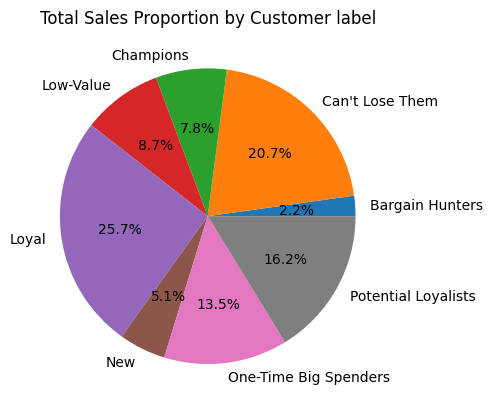

In [38]:
customer_labels_sales = data.groupby("Customer Label")["Sales"].sum()

title = "Total Sales Proportion by Customer label"
plot_piechart(customer_labels_sales.values, customer_labels_sales.index, title)

From the plot above we can conclude the following:

- The Loyal customers account for more than 25% of the entire sales.
- The Champions customers account for nearly double the sales proportion than their proportion size.
- The Can't Lose Them customers account for more than 20% of the total sales. This insight further emphasize the need to perform actions in order to make them re-engage with the store.
- The Low-Value customers account sales proportion is only a third of their proportion size.
- The Bargain Hunters account for the lowest sales proportion, with a proportion of ~2%.

Now, let us compare the sales distribution with the profit distribution:

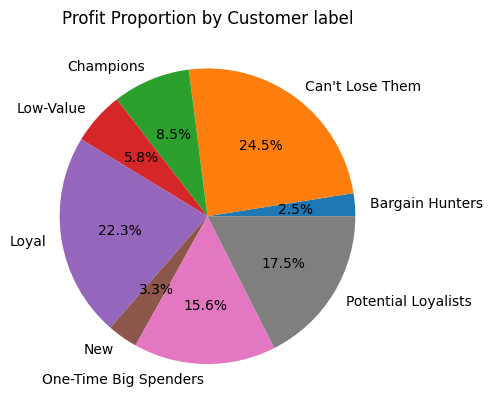

In [39]:
customer_labels_profit = data.groupby("Customer Label")["Profit"].sum()

title = "Profit Proportion by Customer label"
plot_piechart(customer_labels_profit.values, customer_labels_profit.index, title)

As we can see, this plot highly resembles the previous graph.

That is, there is not a significant change between the sales and profit proportion of each of the customer labels.

Now, let us find the customer label distribution for each of the given segments (Consumer, Corporate and Home Office):

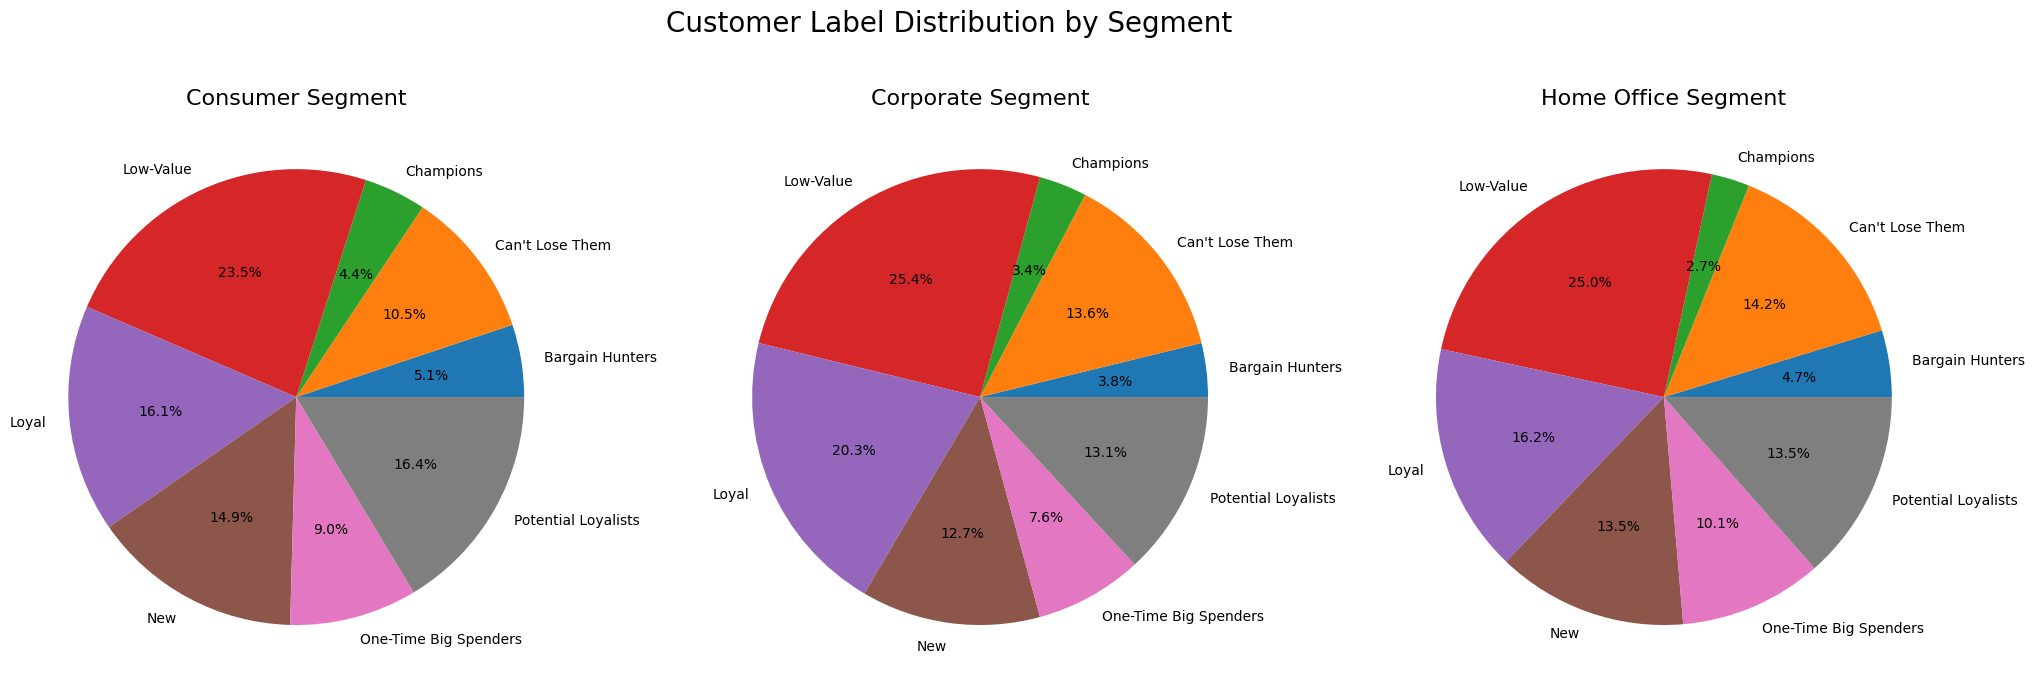

In [40]:
segments = data["Segment"].unique()

fig, axis = plt.subplots(1, 3, figsize=(25, 8))
plt.subplots_adjust(wspace=0.2)
for i, segment in enumerate(segments):
    df = data[data["Segment"] == segment].groupby("Customer Label").apply(lambda x: x["Customer ID"].nunique())
    axis[i].pie(df.values, labels=df.index, autopct="%1.1f%%")
    axis[i].set_title(f"{segment} Segment", fontsize=16)

plt.suptitle("Customer Label Distribution by Segment", fontsize=20)
plt.show()

From the plots above we can conclude the following:

- The label distribution of each segment is approximately the same, and it is very similar to the overall label distribution.
- The Consumer segment has the highest Champions proportion. However, the absolute percentage different is small (<1.5).
- The Loyal and Can't Lose Them labels have the largest difference between the different segments (~4%), with the Corporate and Home Office segments having the highest proportion respectively.

Lastly, let us rank the various customer labels based on their profit-sales ratio:

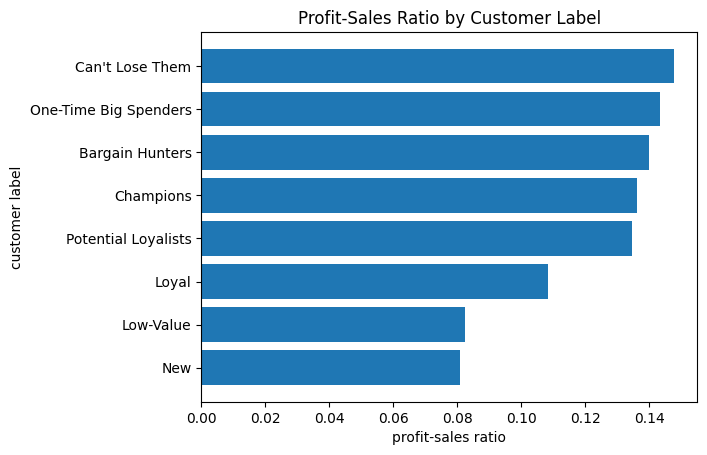

In [41]:
customer_labels_profit_sales_ratio = data.groupby("Customer Label")\
                                         .apply(lambda x: x["Profit"].sum() / x["Sales"].sum())\
                                         .sort_values()

title = "Profit-Sales Ratio by Customer Label"
x_label = "profit-sales ratio"
y_label = "customer label"
plot_horizontal_barchart(customer_labels_profit_sales_ratio.index, customer_labels_profit_sales_ratio.values,
                         title, x_label, y_label)

From the above plot we can conclude the following:

- The Can't Lose Them customers have the highest profit-sales ration. This insight further deepens the importance of making them re-engage.
- The Values' decrease is quite subtle. In particular, the ratio of the top 4 labels is roughly the same.
- The ratio of the Loyal customers is third to last. This is unfortunate since we saw these costumers account for the highest proportion of the total sales.
- The ratio of the New customers is the lowest.
- The ratio of the Low-Value customer is second to last. This is good news since these customers are not much valued.

### Required Action Customers 

By our segments definition, the most important groups that require action are:

- Cant Lose Them - need immediate action in order to make them re-engage with the store, and return them as valuable customers.

- Potential Loyalists - need action in order to convert them to Loyal customers.

As a result, let us find each group's number of customers by state in order to better manage the marketing efforts.

**Cant Lose Them:**

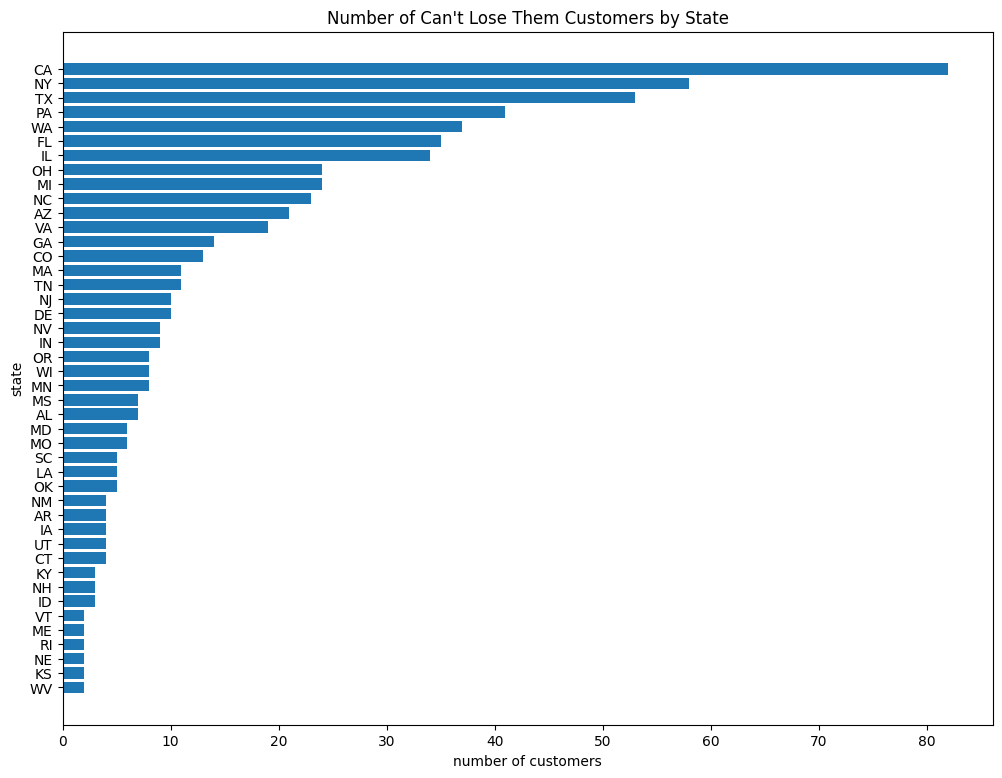

In [42]:
cant_lose_them_states = data[data["Customer Label"] == "Can't Lose Them"].groupby("State")\
                                                                         .apply(lambda x: x["Customer ID"].nunique())\
                                                                         .sort_values(ascending=True)
title = "Number of Can't Lose Them Customers by State"
x_label = "number of customers"
y_label = "state"
plot_horizontal_barchart(cant_lose_them_states.index, cant_lose_them_states.values, title, x_label, y_label, figsize=(12, 9))

From the plot above we can conclude the following:

- California is the state with the highest number of Can't Lose Them customers.
- The values' decrease is quite rapid. However, all states contain some number of Can't Lose Them customers.

**Potential Loyalists:**

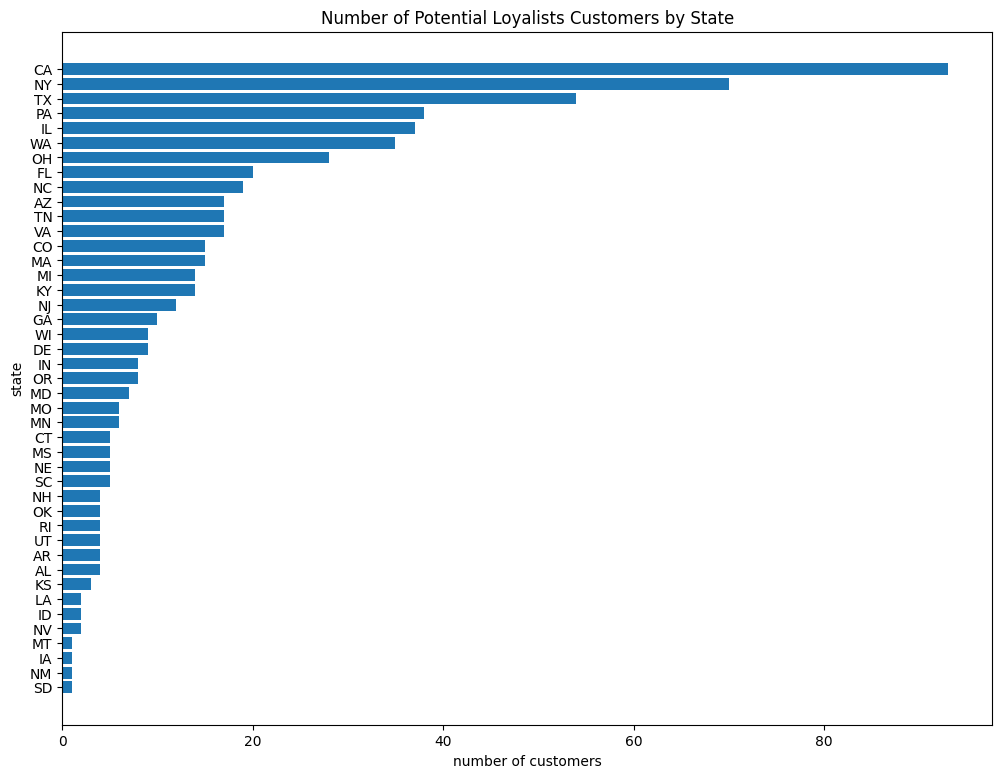

In [43]:
potential_loyalists_states = data[data["Customer Label"] == "Potential Loyalists"].groupby("State")\
                                                                             .apply(lambda x: x["Customer ID"].nunique())\
                                                                             .sort_values(ascending=True)

title = "Number of Potential Loyalists Customers by State"
x_label = "number of customers"
y_label = "state"
plot_horizontal_barchart(potential_loyalists_states.index, potential_loyalists_states.values, title, x_label, y_label, figsize=(12, 9))

As we can see, the top 4 states with the highest number of Potential Loyalists are the same as the ones from the previous plot.

This insight significantly elevates said states importance.

### Best Customers

By definition, the best customers are Champions and Loyal customers.

Let us explore their characteristics:

In [44]:
# filter the data to only contain "best customers"
best_customers_data = data[data["Customer Label"].isin(["Champions", "Loyal"])]

First, let us find the sales distribution by category:

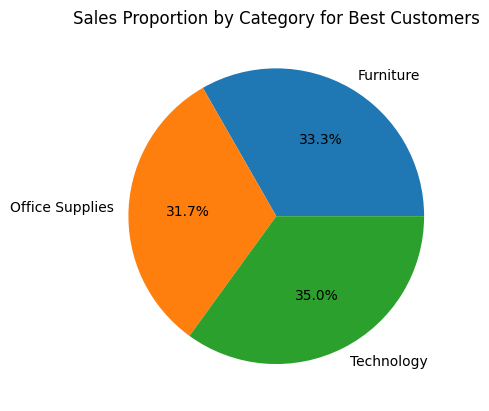

In [45]:
df = best_customers_data.groupby("Category")["Sales"].sum()

title = "Sales Proportion by Category for Best Customers"
plot_piechart(df.values, df.index, title)

As we can see, the distribution is quite uniform.

That is, the best customers do not buy products from a specific category (in terms of total sales).

Now, let us find the top 10 highest profit products:

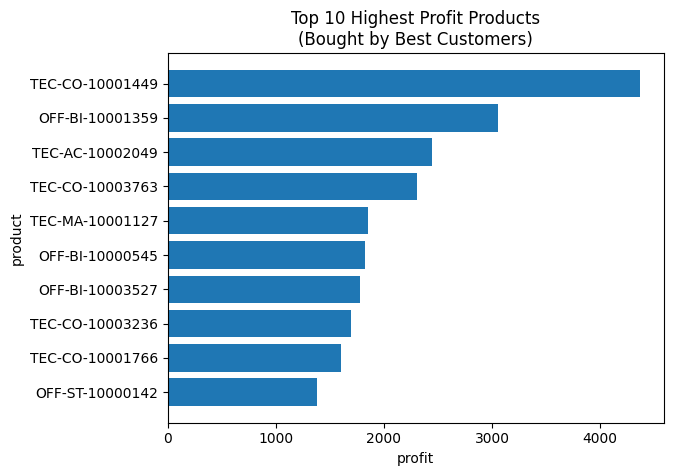

In [46]:
df = data[data["Customer Label"].isin(["Champions", "Loyal"])].groupby("Product ID")["Profit"].sum().sort_values(ascending=False)

best_products = list(df.index[:10])
best_profit = list(df.values[:10])

best_products.reverse()
best_profit.reverse()

title = "Top 10 Highest Profit Products\n(Bought by Best Customers)"
x_label = "profit"
y_label = "product"
plot_horizontal_barchart(best_products, best_profit, title, x_label, y_label)

From the plot above we can conclude the following:

- The best profit product is 'TEC-CO-10001449' (Hewlett Packard LaserJet 3310 Copier), and quite by far.
- The values' decrease is quite moderate (compared to the other graphs seen so far).

## Future Sales Forecast

In this section, our goal is to fit a statistical model in order to predict the future sales of the following 12 months.

The statistical model architecture we will choose for this task is $SARIMA$.

### Time Series Stationarity 

In order to correctly choose our predicative model, we will need the time series to be stationary.

Hence, in this section, we will check if this property indeed holds, and perform necessary transformations if not.

First, let us create the time series:

In [47]:
ts = data.groupby("Order Month")[["Sales"]].sum()

Now, let us plot it:

*Note that we have already created this plot under the EDA section.

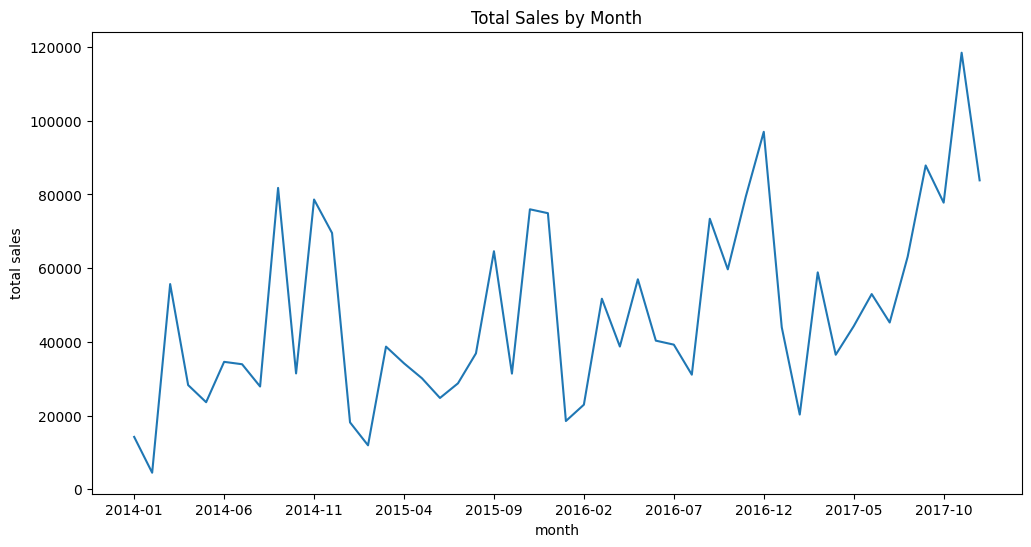

In [48]:
dates = [str(x) for x in ts.index]
values = ts.values

title = "Total Sales by Month"
x_label = "month"
y_label = "total sales"
plot_lineplot(dates, values, title, x_label, y_label,
              figsize=(12, 6), x_ticks=[i for i in range(0, len(dates), 5)])

As discussed in the previous sections, there is some degree of yearly seasonality. As a result, the series is not stationary.

Let us try to remove the seasonality by performing differentiation of 12 time periods:

*Formally, we will define the following new time series: $Y_t = X_t - X{t-12}$.

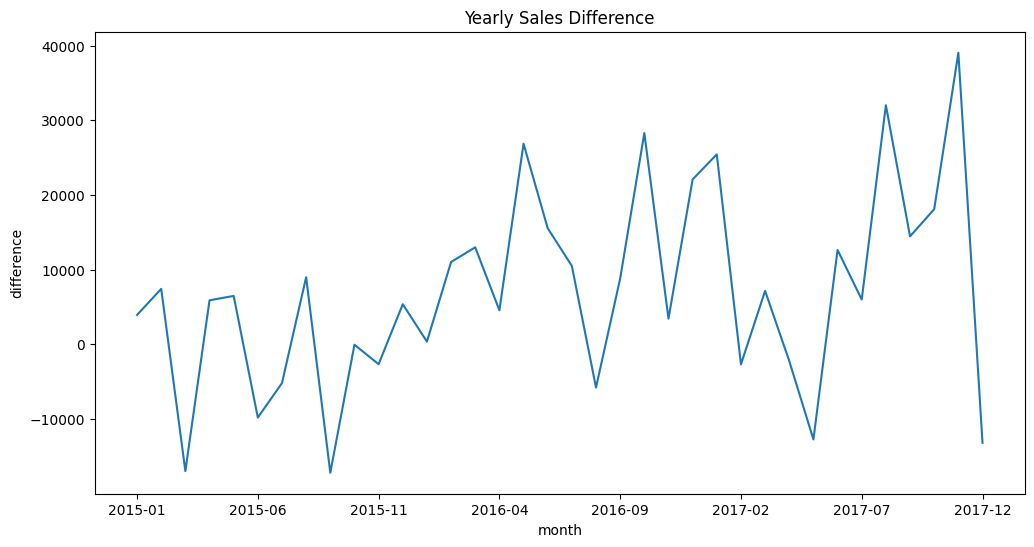

In [49]:
ts_diff = ts.diff(periods=12)
ts_diff.dropna(inplace=True)

title = "Yearly Sales Difference"
x_label = "month"
y_label = "difference"

dates = [str(x) for x in ts_diff.index]
values = ts_diff.values

plot_lineplot(dates, values, title, x_label, y_label,
              figsize=(12, 6), x_ticks=[i for i in range(0, len(dates), 5)])

As we can see, the seasonality is indeed less apparent. However, there is still of upward trend. As a result, the transformed time series is still not stationary.

Let us try to remove it by performing differentiation of a single time period:

*Formally, we will define the following new time series: $Z_t = Y_t - Y_{t-1}$.

 

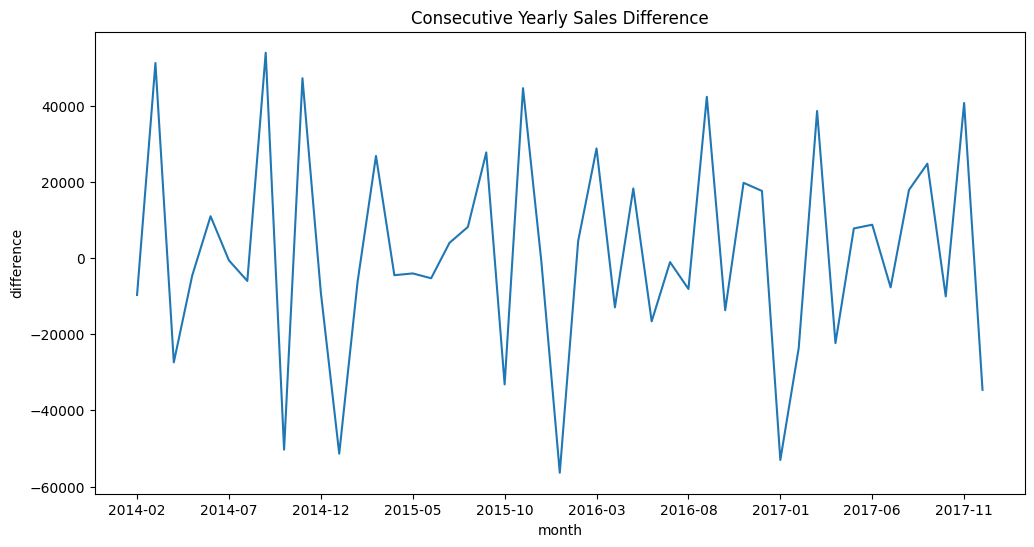

In [50]:
ts_diff_diff = ts.diff(periods=1)
ts_diff_diff.dropna(inplace=True)

title = "Consecutive Yearly Sales Difference"
x_label = "month"
y_label = "difference"

dates = [str(x) for x in ts_diff_diff.index]
values = ts_diff_diff.values

plot_lineplot(dates, values, title, x_label, y_label,
              figsize=(12, 6), x_ticks=[i for i in range(0, len(dates), 5)])

As we can see, we have succeeded in removing the trend. Now, the transformed time series appear to be stationary.

Let us further validate our conclusion by performing the augmented Dickey–Fuller statistical test:


In [51]:
adftest = adfuller(ts_diff_diff['Sales'], autolag='AIC', regression='ct')
print("------------ADF Test Results------------")

print("\nNull Hypothesis: The series has a unit root (non-stationary)\n")

print("ADF-Statistic:", round(adftest[0], 3))
print("P-Value:", round(adftest[1], 6))

------------ADF Test Results------------

Null Hypothesis: The series has a unit root (non-stationary)

ADF-Statistic: -9.572
P-Value: 0.0


As we can see, $PV \approx 0$. Therefore, we will reject the null hypothesis for any confidence level.

In other words, there is  a strong statistical significance that our transformed time series is indeed stationary.

### Model Selection

In order to correctly choose our $SARIMA$ model, we will analyze the ACFs and PACFs of our transformed time series. Note that since our transformed time series is stationary, we are able to calculate them (as they are well-defined). Let us plot them:

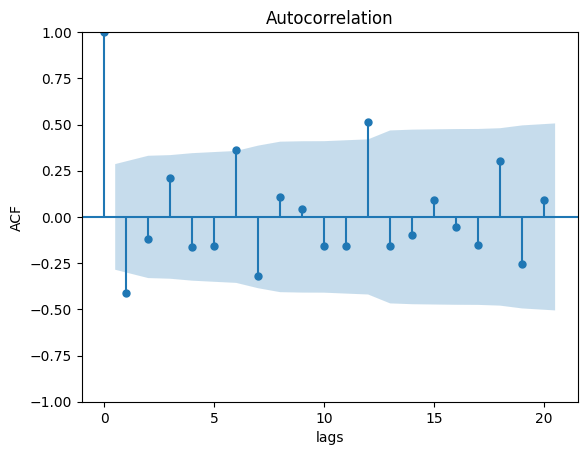

In [52]:
tsaplots.plot_acf(ts_diff_diff, lags=20)
plt.xlabel("lags")
plt.ylabel("ACF");

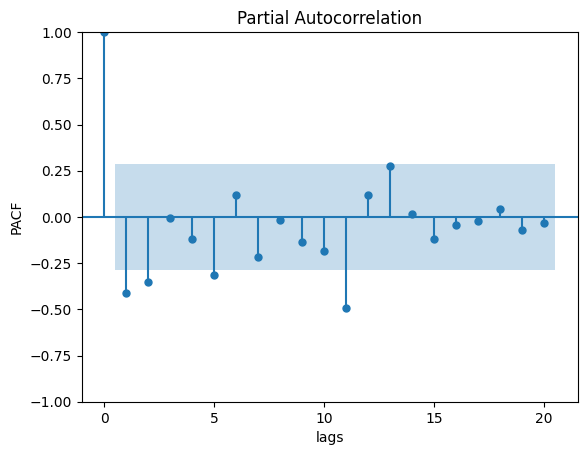

In [53]:
tsaplots.plot_pacf(ts_diff_diff, lags=20)
plt.xlabel("lags")
plt.ylabel("PACF");

From the graphs above we can conclude the following:

- The first ACF is clearly not zero.
- The rest of the ACFs appear to decay to zero and/or be approximately zero.
- The first and second PACFs are clearly not zero.
- The rest of the PACFs appear to decay to zero and/or be approximately zero.

As a result, we can conclude that the models which are probably suitable for the transformed time series are: $MR(1)$, $AR(1)$ or $AR(2)$.

Therefore, models that might fit the original time series are:

- Model 1 - $SARIMA(0, 1, 1)(0, 1, 0)_{12}$
- Model 2 - $SARIMA(1, 1, 0)(0, 1, 0)_{12}$
- Model 3 - $SARIMA(2, 1, 0)(0, 1, 0)_{12}$
- Model 4 - $SARIMA(1, 1, 1)(0, 1, 0)_{12}$
- Model 5 - $SARIMA(2, 1, 1)(0, 1, 0)_{12}$

### Model Comparison

In this section, we will compare the suggested models, and choose the best fitting one.

we will evaluate each of model based on the following metrics:

- BIC score
- RMSE score – we will split the data into train and test sets, where the train set consists of the first 85% of the records, and the test set consists of the last 15% of the records . Then, we will train each model on the train set, create a forecast for the test set, and calculate the MSE between the forecasted values and the true values.

*Note that in both metrics, a **lower** score implies a **better** model.

Let us create a function that will compute the RMSE based on the mentioned procedure:

In [69]:
def calc_model_RMSE(df, order, seasonal_order):
  n = len(df)
  slice_idx = int(n * 0.85)

  # take 85% of the data as the train set
  train_df = df[:slice_idx]

  # take 15% of the data as the test set
  test_df = df[slice_idx:]

  model = SARIMAX(train_df, order=order, seasonal_order=seasonal_order)
  model = model.fit()

  pred_num = n - slice_idx
  forcasts = model.get_forecast(steps=pred_num)
  preds = forcasts.predicted_mean
  residuals = np.array(test_df["Sales"]) - np.array(preds)

  RMSE = ((residuals ** 2) ** 0.5).mean()

  return RMSE

**Model 1:**

In [55]:
model_1 = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12))
model_1 = model_1.fit()

print(model_1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -388.708
Date:                             Fri, 16 Aug 2024   AIC                            781.416
Time:                                     16:13:30   BIC                            784.526
Sample:                                 01-31-2014   HQIC                           782.489
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4164      0.102     -4.088      0.000      -0.616      -0.217
sigma2      2.435e+08   5.7

In [71]:
model_1_RMSE = calc_model_RMSE(ts, order=(0, 1, 1), seasonal_order=(0, 1, 0 ,12))
print(f"Model 1 RMSE score: {(model_1_RMSE / 1000):.2f}K")

Model 1 RMSE score: 18.24K


The results for model 1 are:

- BIC - 784.5
- RMSE - 18.24k

**Model 2:**

In [57]:
model_2 = SARIMAX(ts, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
model_2 = model_2.fit()

print(model_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -388.493
Date:                            Fri, 16 Aug 2024   AIC                            780.987
Time:                                    16:13:30   BIC                            784.097
Sample:                                01-31-2014   HQIC                           782.060
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4286      0.116     -3.709      0.000      -0.655      -0.202
sigma2      2.367e+08   5.44e-11   

In [72]:
model_2_RMSE = calc_model_RMSE(ts, order=(1, 1, 0), seasonal_order=(0, 1, 0 ,12))
print(f"Model 2 RMSE score: {(model_2_RMSE / 1000):.2f}K")

Model 2 RMSE score: 18.59K


The results for model 2 are:

- BIC - 784.1
- RMSE - 18.59k

**Model 3:**:

In [59]:
model_3 = SARIMAX(ts, order=(2, 1, 0), seasonal_order=(0, 1, 0, 12))
model_3 = model_3.fit()

print(model_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -389.578
Date:                            Fri, 16 Aug 2024   AIC                            785.157
Time:                                    16:13:30   BIC                            789.823
Sample:                                01-31-2014   HQIC                           786.768
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4487      0.084     -5.339      0.000      -0.613      -0.284
ar.L2         -0.0654      0.082   

In [73]:
model_3_RMSE = calc_model_RMSE(ts, order=(2, 1, 0), seasonal_order=(0, 1, 0 ,12))
print(f"Model 3 RMSE score: {(model_3_RMSE / 1000):.2f}K")

Model 3 RMSE score: 18.58K


The results for model 3 are:

- BIC - 789.8
- RMSE - 18.58k

**Model 4:**

In [61]:
model_4 = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12))
model_4 = model_4.fit()

print(model_4.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -388.532
Date:                             Fri, 16 Aug 2024   AIC                            783.065
Time:                                     16:13:30   BIC                            787.731
Sample:                                 01-31-2014   HQIC                           784.675
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3253      0.267     -1.217      0.224      -0.849       0.199
ma.L1         -0.1209      

In [74]:
model_4_RMSE = calc_model_RMSE(ts, order=(1, 1, 1), seasonal_order=(0, 1, 0 ,12))
print(f"Model 4 MSE score: {(model_4_RMSE / 1000):.2f}K")

Model 4 MSE score: 18.58K


The results for model 4 are:

- BIC - 787.7
- RMSE - 18.58k

**Model 5:**

In [63]:
model_5 = SARIMAX(ts, order=(2, 1, 1), seasonal_order=(0, 1, 0, 12))
model_5 = model_5.fit()

print(model_5.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -386.256
Date:                             Fri, 16 Aug 2024   AIC                            780.513
Time:                                     16:13:31   BIC                            786.734
Sample:                                 01-31-2014   HQIC                           782.660
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2007      0.197     -6.097      0.000      -1.587      -0.815
ar.L2         -0.3761      

In [75]:
model_5_RMSE = calc_model_RMSE(ts, order=(2, 1, 1), seasonal_order=(0, 1, 0 ,12))
print(f"Model 5 MSE score: {(model_5_RMSE / 1000):.2f}K")

Model 5 MSE score: 19.18K


The results for model 5 are:

- BIC - 786.7
- RMSE - 19.18k

**Summarizing the results:**

| Model | BIC   | RMSE   |
|-------|-------|--------|
| 1     | 784.5 | 18.24K |
| 2     | 784.1 | 18.59K |
| 3     | 789.8 | 18.58K |
| 4     | 787.7 | 18.58K |
| 5     | 786.7 | 19.18K |


As we can see, all the models' have approximately the same BIC score. 

However, while models 2-4 have the same RMSE score (and model 5 have the worst score), model 1 achieved quite a better result.

As a result, we will choose model 1 as our best model.

In [65]:
# set model 1 as our best model
best_model = model_1

### Best Model

First, let us visually assess our model's performance by displaying its residuals plot:

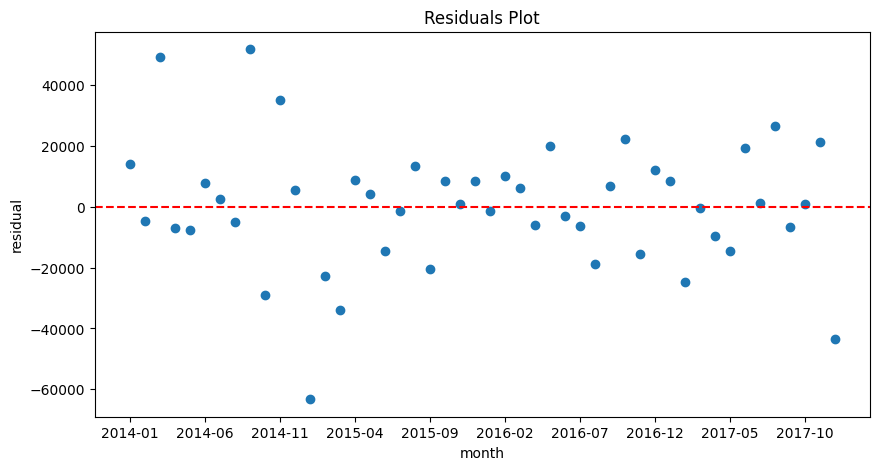

In [66]:
residuals = best_model.resid
dates = [str(x) for x in ts.index]

title = "Residuals Plot"
x_label = "month"
y_label = "residual"
plot_scatterplot(dates, residuals, title, x_label, y_label, hline=0,
                 figsize=(10, 5), x_ticks=[i for i in range(0, len(dates), 5)])

From the above plot we can conclude the following:

- The residuals appear to be symmetrically around the line $y=0$. This highly indicates that the expected error is 0.
- The residuals appear to be around a constant beam. This highly indicates that the variance is constant.

These insights further highlight the strong fit of our model.

Lastly, let us finally achieve this section goal, and use our chosen model to predicate the future sales of the next 12 months:

In [67]:
# make the predications
future_dates = pd.period_range(start="2018-01", end="2018-12", freq="M")
steps = 12
forecasts = best_model.forecast(steps=steps).values

# organize the results in a dataframe
forecasts_df = pd.DataFrame({"Future Month": future_dates,
                             "Forecast": forecasts})


forecasts_df.set_index("Future Month", inplace=True)
forecasts_df

,Forecast
Future Month,
2018-01,48841.381935
2018-02,25171.141335
2018-03,63742.360735
2018-04,41391.544035
2018-05,49131.118135
2018-06,57851.733635
2018-07,50134.423935
2018-08,67990.895935
2018-09,92736.659935


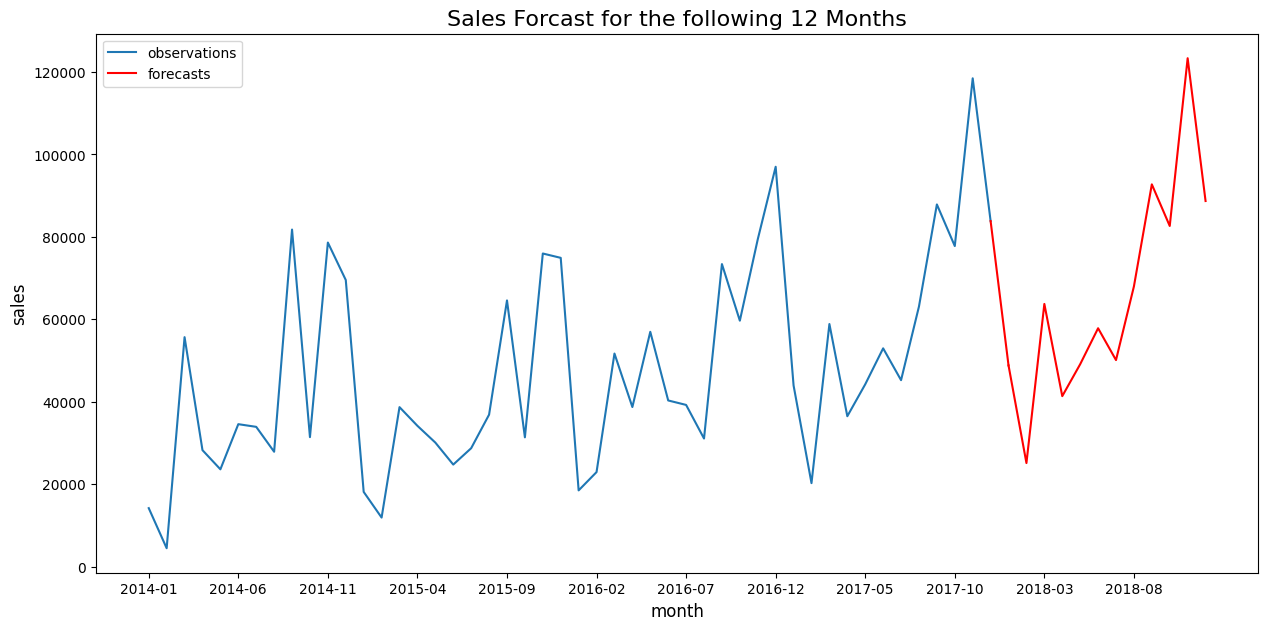

In [68]:
plt.figure(figsize=(15, 7))

# plot the observations
past_dates = [str(x) for x in ts.index]
values = ts.values
plt.plot(past_dates, values, label="observations")

# plot the future predications
future_dates = [str(date) for date in forecasts_df.index]
forecasts = forecasts_df["Forecast"]
plt.plot(future_dates, forecasts, color="r", label="forecasts")

# connect the last observation with the first prediction
connect_dates = [past_dates[-1], future_dates[0]]
connect_values = [ts.values[-1][0], forecasts[0]]
plt.plot(connect_dates, connect_values, color="r")


plt.title("Sales Forcast for the following 12 Months", fontsize=16)
plt.ylabel("sales", fontsize=12)
plt.xlabel("month", fontsize=12)
plt.xticks(ticks=[i for i in range(0, 60, 5)])
plt.legend()
plt.show()

From the plot above we can conclude the following:

- It appears that our model does a great job at capturing the characteristics and intricacies of the time series.
- The model predicts a severe decrease in sales between the end of 2017 and the start of 2018. Although this prediction is unfortunate, it is not surprising since this phenomenon exists in all past observed years.
- The model predicts the continuation of the upward trend in sales. This is great news for the store.